# Executive Summary


The primary goal of this project was to predict the monthly income of a host on AirBnB. The secondary goal was to determine a list of key features that impact income mostly, whether that’s positively or negatively. The idea behind this, is that a consultant / AirBnB can not only give income predictions to hosts, but also guide them in improving income by changing / adding features (e.g. a hair dryer / improve their response rate).

A key metric of this project was the accuracy score from the model predicting income. In a practical sense, it’s important to get the accurate as possible for the sake of hosts and their expectations. Another metric was achieving a high precision score to avoid false-positives, i.e. avoid telling hosts they’ll get a higher income than they actually will get.

After trying both regression and classification models on income, the best accuracy came from a SVC - 73%. The RandomForestClassifier was second best with 72%, but more insightful in terms of answering my secondary question - which features are important in predicting income. For even more insight on this, I looked at the Lasso Regression, which, even though with just 34% accuracy, allowed us to look at coefficients i.e. for every unit increase in a feature, how much did it increase/decrease income.

In fact, across both classification and regression, models showed similar lists of important features. For example:

•  Every £1 extra price per night = £160 more income pm. Charge more money!

•  Every extra person a listing can accommodate = +£30 more income pm. Add an extra sofa bed!

•  Every extra listing a host has = -£50 income pm (on an individual listing). Spreading themselves too thin?

Other key features include:

•  How long ago the first and last reviews were written

•  Distance to the British Museum and Churchill War Rooms

•  How long one has been a host for

•  How many people a listing can accommodate

•  Proximity to nearest Tube station

•  The sentiment behind written reviews of a listing

•  How many amenities a listing has

•  Number of bathrooms

•  Host response time

While a very respectable accuracy score from both classification models, particularly the first, there are certainly limitations and risks within this model. The main one being that the target variable, income, was estimated to begin with. The formula was a slightly adjusted version of one stated by an online source independent from AirBnB.

A huge assumption of this project was that all hosts have live listings and want as much occupancy/income as they can get. But this is simply not the case in reality - some hosts just want to rent out their home while they go away for a weekend here and there. We don’t have this knowledge though, so our data can behave very erratically i.e. you may have a luxury listing that has a great host, great ratings but only rents out 2 days a month, making relatively less income than it could if it actively listed all month long.

The data used for this project was one snapshot in time (March 2019) in London, which was definitely a risk. Ideally, time series data would be taken into account (perhaps panel regression), so seasonality could be taken into account, and more importantly, varying behaviour per listing. For example, a host in March 2019 may have decided to not rent out their listing, but the rest of the year rents it in full force. This would have led to inaccuracy in the model.
Another limiting issue was how diverse London is and the behaviour of different areas. For example, a borough like Hillingdon (near Heathrow airport) had the highest occupancy rate, yet low prices. Whereas City of London had few listings yet one of the highest average incomes. This was slightly delved into, where model scores on a constant set of predictors were compared by borough - there was significant variance. There is certainly potential for unique models per borough, tailored to the behaviour of that certain borough.

In production, this model could be used by AirBnB or an independent consultancy. Hosts signing up for the first time could input their variables (e.g. how much they plan to price at, number of bathrooms, bedrooms, their intended occupancy rate etc.), and get an output of expected income per month. It could also be used to advise current hosts on how to improve income. Using the coefficients from Linear Regression, or feature importance from the RandomForests, one could highlight which features are important in determining income, and even how much income may increase per month given certain changes.

In [36]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
scaler = StandardScaler()
lr = LinearRegression()
import warnings
warnings.filterwarnings("ignore")

# Data Collection

Data was pulled in csv format from InsideAirBnB (http://insideairbnb.com/get-the-data.html), a site that has pre-scraped data from AirBnB's open API per month spanning back to 2015.

I'll be using the combined AirBnB listing data from March and February 2019 ("data_mf"). This data includes 106 features across 83988 unique listings in London. I would have combined more months worth of listings (possibly adding more data points to the set), but as the months went back, different features were/weren't present.

**Download London 07 March, 2019 listings.csv.gz, reviews.csv.gz and 05 February, 2019 listings.csv.gz to access this data and run it on this notebook. Note that further long here, I'll be importing cleaned data from other notebooks - you will need to run these too**

# Import March 2019 & February 2019 Data

In [37]:
mar19 = pd.read_csv("/Users/bridmcnulty/Desktop/listings.csv", low_memory=False)
feb19 = pd.read_csv("/Users/bridmcnulty/Desktop/feb2.csv", low_memory=False)

# Creating Main Dataframe

In [38]:
print(mar19.shape)
print(feb19.shape)

(79129, 106)
(78415, 106)


In [39]:
# Joining March 19 and Feb 19 data together and dropping listing duplicates as we only want unique listings.

frames = [mar19, feb19]

data_mf = pd.concat(frames)
# 157544 rows, 106 cols

# Drop duplicates, keep first only
data_mf.drop_duplicates(subset ="id",keep = 'first', inplace = True) 
data_mf.shape
# Left with an extra 5,000 unqiue listings versus just using March 19

(83988, 106)

In [40]:
# A quick glimpse at the data:

data_mf.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20190307140352,2019-03-08,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,f,f,moderate,f,f,3,1,2,0,0.13
1,15400,https://www.airbnb.com/rooms/15400,20190307140352,2019-03-08,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.72


In [41]:
# Taking a look at the full list of columns (106)
for a in data_mf.columns:
    print(a)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
minimum_maximum_nights
maximum_maximum_nights
minimum_ni

# Cleaning: Begin With High-Level Organizing

Evidently, there are a LOT of features to work with. Below I've split the features into groups, to organize and understand what data we have:

1) Fixed features: something that is within the host's control to change (within reason)

2) Variable features: something within the host's control to change (within reason)

3) Qualitative listing description features: written text by the host displayed on the listing page.

4) Host features: variables related to the host themself, regardless of listing (many have more than one listing)

5) Discarded features: Those that have a lot of nulls and/or are not of interest and/or overlap with other features (e.g. city=London, state=London)

6) Output features that are a result of features listed above. Including: review-related and availability-related features.

* To better understand the features, refer to the Data Dictionary file

In [42]:
# FIXED features:
fixed_features = ['host_since','host_listings_count',
'neighbourhood_cleansed','latitude','longitude','property_type','room_type','accommodates',
'bathrooms','bedrooms','beds','bed_type','first_review']

# UNFIXED features:
variable_features = ['name','summary','space','description','experiences_offered', 'neighborhood_overview','notes','transit',
'access','interaction','house_rules','host_name','host_about','host_response_time','host_response_rate',
'host_is_superhost','host_verifications','host_has_profile_pic','host_identity_verified','is_location_exact',
'amenities','price','security_deposit','cleaning_fee','guests_included',
'extra_people','minimum_nights','maximum_nights','calendar_updated','instant_bookable'
,'cancellation_policy','require_guest_profile_picture','require_guest_phone_verification','experiences_offered']

# Qualitative descriptions of listings written by host:
listings_qual_description = ['name','summary','space','description','neighborhood_overview','notes',
'transit','access','interaction','house_rules']

# Host related features:
host_features = ['host_id','host_name','host_since_ago','host_location','host_about','host_response_time',
'host_response_rate','host_is_superhost','host_thumbnail_url','host_picture_url',
'host_neighbourhood','host_listings_count','host_verifications','host_has_profile_pic','host_identity_verified']

# In neither category because they're not of interest and/or have almost all nulls:
removed_features= ['thumbnail_url','medium_url','picture_url','xl_picture_url','host_url','host_thumbnail_url',
 'host_picture_url','calendar_last_scraped','requires_license','license','jurisdiction_names','host_acceptance_rate',
 'market','smart_location','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights',
 'maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','scrape_id',
'street','host_location', 'neighbourhood_group_cleansed','neighbourhood', 'host_neighbourhood',
 'state','city','weekly_price','monthly_price','square_feet','has_availability','zipcode','is_business_travel_ready','calculated_host_listings_count',
'country','country_code','listing_url','last_scraped','is_location_exact','calculated_host_listings_count_entire_homes',
'calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','host_total_listings_count',
    'calendar_updated','number_of_reviews_ltm']

# Note that the address-related features above were left out from fixed features because only one is really needed: neighbourhood_cleansed.
# This feature is essentially the borough the listing is in. The data is pre-cleansed. Other address related features like street or postcode have too many unique values, and others like city are superfluous as they should all be London.
# 'has_availability' was discarded because ALL have availability.
# 'is_business_travel_ready' discarded as NONE are.

# OUTPUT features:

# Review related features:
reviews_features = ['number_of_reviews','last_review',
'review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',
'review_scores_communication','review_scores_location','review_scores_value','reviews_per_month']

# Availability features:
avail_features = ['availability_30','availability_60','availability_90','availability_365']

# Cleaning: Move On To Dealing With Nulls

Above I mentioned a handful of features in the removed_features list. We can see below in more detail what I was referring to. 
 
Luckily, most features have zero nulls, a handful have mostly nulls, and a handful have 20-30,000 nulls. And there isn't too much overlap.

In [43]:
data_mf.isnull().sum()

id                                                  0
listing_url                                         0
scrape_id                                           0
last_scraped                                        0
name                                               27
summary                                          3623
space                                           26279
description                                      1620
experiences_offered                                 0
neighborhood_overview                           32071
notes                                           51193
transit                                         32010
access                                          36429
interaction                                     36507
house_rules                                     34897
thumbnail_url                                   83988
medium_url                                      83988
picture_url                                         0
xl_picture_url              

In [44]:
# Side note:
    # It would have been really nice to get square feet of a house to calculate how spacious it is per person. But square feet is almost all nulls.
data_mf.square_feet.isnull().sum()

83519

In [45]:
# Now we will drop mostly null features:

data_mf = data_mf.drop(columns=removed_features)

In [46]:
# Change cleaning_fee and security_deposit to floats, and fill in NaNs with 0 values. 
    #A null value in either row indicates the host hasn't input any value, meaning they essentially charge zero for both.

def remove_dollar(x):
    try:
        return float(x.replace('$', ''))
    except:
        return 0.00

# Change both to float first:
data_mf["cleaning_fee"] = data_mf["cleaning_fee"].map(remove_dollar)
data_mf["security_deposit"] = data_mf["security_deposit"].map(remove_dollar)

# Fill NaN with 0:
data_mf["cleaning_fee"].fillna(0.00, inplace = True)
data_mf["security_deposit"].fillna(0.00, inplace = True)

In [47]:
# A one-off clean found during some EDA:

    # data_mf[data_mf['country_code'] == 'ES'] ==> This listing is in Ibiza
    # delete this listing, id = 23325697:
data_mf.drop(data_mf[data_mf['id'] == 23325697].index, inplace=True)

Remove rows where 'reviews_per_month' is null (21,305 rows):

As these listings either haven't had any bookings in March hence zero reviews (possibly by choice). Or have had relatively few bookings (possibly ever) and no one has reviewed yet. This clash or possibilities may mean the data around listings with 0 reviews_per_month may be unrepresentative and confusing to train a model on.

Same for 'host_response_time' is null:

This variable is auto-filled by AirBnB with values taking 'within a day', 'within a few hours', 'within an hour', 'a few days or more' and null. So if it's null it means these hosts are completely inactive and their listings. 

In [48]:
# Remove 'reviews_per_month' and 'host_response_time' null rows:

data_mf.dropna(subset=['first_review'],inplace=True)
data_mf.dropna(subset=['host_response_time'],inplace=True)

In [49]:
# Taking another quick look at nulls after removing unwanted features:

for col in data_mf.columns:
    print(data_mf[col].isna().sum(),'-----',col)

0 ----- id
2 ----- name
1595 ----- summary
10735 ----- space
652 ----- description
0 ----- experiences_offered
13945 ----- neighborhood_overview
24602 ----- notes
14170 ----- transit
15903 ----- access
16496 ----- interaction
16327 ----- house_rules
0 ----- host_id
0 ----- host_name
0 ----- host_since
16297 ----- host_about
0 ----- host_response_time
0 ----- host_response_rate
0 ----- host_is_superhost
0 ----- host_listings_count
0 ----- host_verifications
0 ----- host_has_profile_pic
0 ----- host_identity_verified
0 ----- neighbourhood_cleansed
0 ----- latitude
0 ----- longitude
0 ----- property_type
0 ----- room_type
0 ----- accommodates
37 ----- bathrooms
19 ----- bedrooms
27 ----- beds
0 ----- bed_type
0 ----- amenities
0 ----- price
0 ----- security_deposit
0 ----- cleaning_fee
0 ----- guests_included
0 ----- extra_people
0 ----- minimum_nights
0 ----- maximum_nights
0 ----- availability_30
0 ----- availability_60
0 ----- availability_90
0 ----- availability_365
0 ----- number_of_

In [50]:
# Make a quick copy of the main df so far. Let's delete all rows with nulls and see how much is left over:
test = data_mf.copy()
test.dropna(inplace=True)
test.shape

# It's still fairly big but we've lost a lot of data...

(9454, 60)

In [51]:
# Back to our main df, let's try excluding listings_qual_description features as that's where most nulls are at the moment:

data_mf.drop(columns=listings_qual_description,inplace=True)
data_mf.shape

(46533, 50)

In [52]:
for col in data_mf.columns:
    print(data_mf[col].isna().sum(),'-----',col)

0 ----- id
0 ----- experiences_offered
0 ----- host_id
0 ----- host_name
0 ----- host_since
16297 ----- host_about
0 ----- host_response_time
0 ----- host_response_rate
0 ----- host_is_superhost
0 ----- host_listings_count
0 ----- host_verifications
0 ----- host_has_profile_pic
0 ----- host_identity_verified
0 ----- neighbourhood_cleansed
0 ----- latitude
0 ----- longitude
0 ----- property_type
0 ----- room_type
0 ----- accommodates
37 ----- bathrooms
19 ----- bedrooms
27 ----- beds
0 ----- bed_type
0 ----- amenities
0 ----- price
0 ----- security_deposit
0 ----- cleaning_fee
0 ----- guests_included
0 ----- extra_people
0 ----- minimum_nights
0 ----- maximum_nights
0 ----- availability_30
0 ----- availability_60
0 ----- availability_90
0 ----- availability_365
0 ----- number_of_reviews
0 ----- first_review
0 ----- last_review
797 ----- review_scores_rating
811 ----- review_scores_accuracy
809 ----- review_scores_cleanliness
824 ----- review_scores_checkin
812 ----- review_scores_commun

In [53]:
# Remove host_about too - it's unlikely I'll use this feature:
data_mf.drop(columns=['host_about'],inplace=True)

In [54]:
# Now remove null rows:
data_mf.dropna(inplace=True)
data_mf.shape

# We're left with 3x more unique listings if we exclude qualitative listing descriptions.

(45616, 49)

**More Cleaning: Tidying up data types and formats**

Clean all columns that are:
    - Price-based
    - In % format
    - Can be binarized

In [55]:
# Clean price-related columns: price, extra_people
data_mf["price"] = data_mf["price"].map(remove_dollar)
data_mf["extra_people"] = data_mf["extra_people"].map(remove_dollar)

In [56]:
# %-related: response_rate

def make_float(x):
    try:
        return float(x.replace('%', ''))
    except:
        return 0.00
    
data_mf["host_response_rate"] = data_mf["host_response_rate"].map(make_float)

In [57]:
# Another one-off clean found during EDA: A listing that accommodates 0 people:

data_mf.drop(data_mf[data_mf['accommodates'] == 0].index, inplace=True)

In [58]:
# Binarize numerically true/false columns:

def binarize(x):
    if x == 't':
        return 1
    else:
        return 0
    
data_mf['host_is_superhost'] = data_mf.host_is_superhost.map(binarize)
data_mf['host_has_profile_pic'] = data_mf.host_has_profile_pic.map(binarize)
data_mf['host_identity_verified'] = data_mf.host_identity_verified.map(binarize)
data_mf['require_guest_profile_picture'] = data_mf.require_guest_profile_picture.map(binarize)
data_mf['require_guest_phone_verification'] = data_mf.require_guest_phone_verification.map(binarize)
data_mf['instant_bookable'] = data_mf.instant_bookable.map(binarize)

In [59]:
# This change in name became relevant for a Tableau visualisation that we'll see later:

data_mf['neighbourhood_cleansed'].replace('Westminster','City of Westminster',inplace=True)

Changing date-based features to days_ago instead of a date, to help with regression modelling.

In [60]:
# Date-related columns: first_review, last_review, host_since
from datetime import datetime

data_mf.first_review = pd.to_datetime(data_mf.first_review)
data_mf['first_review_days_ago'] = datetime.now() - data_mf.first_review
data_mf.first_review_days_ago = data_mf.first_review_days_ago.map(lambda x: x.days)
data_mf.drop(columns='first_review',inplace=True)

data_mf.last_review = pd.to_datetime(data_mf.last_review)
data_mf['last_review_days_ago'] = datetime.now() - data_mf.last_review
data_mf.last_review_days_ago = data_mf.last_review_days_ago.map(lambda x: x.days)
data_mf.drop(columns='last_review',inplace=True)

data_mf.host_since = pd.to_datetime(data_mf.host_since)
data_mf['host_since_ago'] = datetime.now() - data_mf.host_since
data_mf.host_since_ago = data_mf.host_since_ago.map(lambda x: x.days)
data_mf.drop(columns='host_since',inplace=True)

# Feature Engineering

**Tube Proximity**

Trying to find proximity to closest tube station for each listing. This may be more insightful than just neighbourhood.

In [61]:
# Reading in a csv I created, with information sourced from Wikipedia:

tubelocations = pd.read_csv("/Users/bridmcnulty/Desktop/tubelocations1.csv", low_memory=False)
tubelocations.head()

,Name,Latitude,Longitude
0,Acton Town,51.502500,-0.278126
1,Acton Central,51.508835,-0.263033
2,Acton Central,51.508560,-0.262880
3,Aldgate,51.513940,-0.075370
4,Aldgate East,51.515140,-0.071780


In [62]:
# Creating a latitude-longitude zip for the function below:
data_mf['latlongzip'] = list(zip(data_mf.latitude, data_mf.longitude))
tubelocations['latlongzip'] = list(zip(tubelocations.Latitude, tubelocations.Longitude))

In [63]:
# Function to calculate distance (in km) between a listing and it's nearest tube station:
    # Limitation being it's distane 'as the crow flies'. Ideally, it would be walking/cycling distance via Google Maps.

from math import sin, cos, sqrt, atan2, radians

distances = []

for lat, long in data_mf.latlongzip:
    n = float(100.00)
    for lat_tube, long_tube in tubelocations.latlongzip:
    # approximate radius of earth in km
        R = 6373.0

        lat1 = radians(lat)
        lon1 = radians(long)
        lat2 = radians(lat_tube)
        lon2 = radians(long_tube)

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c  # in km
        if distance < n:
            n = distance
    distances.append(n)

# Adding the new column:    
data_mf['tube_proximity'] = distances
data_mf.head(2)

,id,experiences_offered,host_id,host_name,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,...,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month,first_review_days_ago,last_review_days_ago,host_since_ago,latlongzip,tube_proximity
0,13913,business,54730,Alina,within a day,60.0,0,4.0,"['email', 'phone', 'facebook', 'reviews']",1,...,0,moderate,0,0,0.13,3206,346,3481,"(51.568020000000004, -0.11120999999999999)",0.523494
1,15400,romantic,60302,Philippa,within a few hours,100.0,0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1,...,0,strict_14_with_grace_period,1,1,0.72,3446,425,3462,"(51.48796, -0.16898)",0.728651


In [64]:
data_mf.tube_proximity.describe()

count    45615.000000
mean         0.921409
std          1.362453
min          0.003408
25%          0.300221
50%          0.504259
75%          0.925287
max         19.709944
Name: tube_proximity, dtype: float64

In [65]:
# Most are very close to transport links - some are well over 5km. This is because my list of stations didn't extend to overground stations far outside of London.
    # Add to the list or remove these listings.

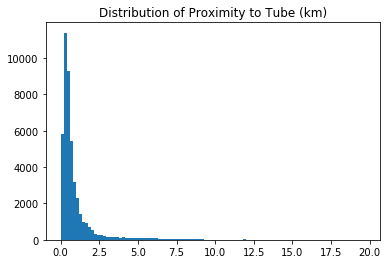

In [66]:
plt.hist(data_mf.tube_proximity,bins=100)
plt.title("Distribution of Proximity to Tube (km)")
plt.show()

In [67]:
# Looking at tube_proximity vs income:
    # FYI: This code includes the income feature that is engineered later on.
plt.figure(figsize=(15,8))
sns.scatterplot(data_mf.tube_proximity, data_mf.income)
plt.xlabel("Tube Proximity km")
plt.ylabel("Income Per Month")
plt.title("Tube Proximity Vs. Income")

plt.show()

AttributeError: 'DataFrame' object has no attribute 'income'

<Figure size 1080x576 with 0 Axes>

**Distance To London's Top 11 Tourist Attractions**

Now we'll find the distance (in km) from each listing to 11 of London's top tourist attractions as sourced from TripAdvisor. The idea here is that most of AirBnB's guests are tourists visiting London, so value might be added to a listing based on how close it is to tourist sites. This could help my model understand why a listing that may not seem that great is earning high income - i.e. location and convenience boosts income!

In [69]:
# Import attractions distance file:

attr = pd.read_csv("/Users/bridmcnulty/Desktop/attractions_distance.csv")
attr.drop(columns=['Unnamed: 0'],inplace=True)
attr.head(1)

,d_british_museum,d_tower_london,d_covent_garden,d_nat_hist_museum,d_nat_gallery,d_st_pauls,d_borough_market,d_va_museum,d_tower_bridge,d_westminster_abbey,d_churchill_war_room,id
0,5.5172,7.098488,6.326645,9.125647,6.681356,6.095644,7.09327,8.995377,7.382254,7.724362,7.428535,13913


In [70]:
# Merge onto main dataframe

data_mf = data_mf.merge(attr,how='left',on='id')
data_mf.head(1)

,id,experiences_offered,host_id,host_name,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,...,d_tower_london,d_covent_garden,d_nat_hist_museum,d_nat_gallery,d_st_pauls,d_borough_market,d_va_museum,d_tower_bridge,d_westminster_abbey,d_churchill_war_room
0,13913,business,54730,Alina,within a day,60.0,0,4.0,"['email', 'phone', 'facebook', 'reviews']",1,...,7.098488,6.326645,9.125647,6.681356,6.095644,7.09327,8.995377,7.382254,7.724362,7.428535


**Adding a 'Price Per Person' Column**

The idea here is that it is difficult to compare listings of the same price when one could accommodate 1 person, and the other 10 people. Hence creating a price per person column.

In [71]:
# Created price per person column:
data_mf['price_pp'] = data_mf.price / data_mf.accommodates
data_mf.price_pp = data_mf.price_pp.apply(lambda x: float(x))

# Creating Occupancy Rate & Income

The most important features to engineer, as income will be the target variable to model on!

Initially, I had used a different formula to calculate occupancy rate: For each listing I used availability_30 (days 'booked' per month) over the last 12 months, as I was able to scrape that column for each month's snapshot over a year. So these 12 values were summed. Then multiplied by price. I later learned that availability_30 isn't reliable enough an indicator of bookings - as it doesn't differentiate between bookings and blocked out dates (e.g. a host doesn't want to list then).

**How Income Was Calculated:**
    
**Income = estimated_monthly_bookings * (price + cleaning_fee)**   

**Occupancy rate = (estimated_monthly_bookings) * (avg_length_of_stay)**

**estimated_monthly_bookings = (reviews_per_month) * (review rate of 50%)**

- 50% review rate is a middle ground between the 70% released by AirBnB themselves (biased) and 30.5% released by The Budget and Legislative Analyst's Office - while this number is likely more fact-based than AirBnB's, it didn't take into account missing reviews because of deleted listings. I chose a conservative middle guess: 50%.
- avg_length_of_stay for London has been released by AirBnB as 4.6 days. Where a listing's minimum_stay > 4.6, the avg_length_of_stay will be it's minimum_stay.

NOTE: All occupancy rates will be capped at 82% - London's annual hotel occupancy rate uppper bound.

In [72]:
# 1. Calculating estimated_monthly_bookings:
data_mf['estimated_monthly_bookings'] = data_mf.reviews_per_month * 2

In [73]:
# Calculating avg_length_of_stay:

avg_stay = []

for l in data_mf.minimum_nights:
    if l > 4.6:
        avg_stay.append(l)
    else:
        avg_stay.append(4.6)

data_mf['avg_length_of_stay'] = avg_stay

In [74]:
# Calculating new_or:

data_mf['new_or'] = (data_mf.avg_length_of_stay * data_mf.estimated_monthly_bookings)/100

# Capping new_or at maximum 80%:

capped_or = []

for o in data_mf.new_or:
    if o > 0.8:
        capped_or.append(0.8)
    else:
        capped_or.append(o)

data_mf['capped_or'] = capped_or

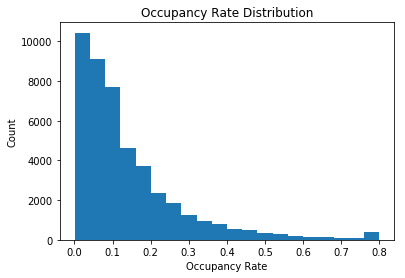

In [75]:
plt.hist(data_mf.capped_or,bins=20)
plt.title("Occupancy Rate Distribution")
plt.xlabel("Occupancy Rate")
plt.ylabel("Count")
plt.show()

In [76]:
#Calculating Income:

data_mf['income'] = (data_mf.capped_or*31)*data_mf.price + (data_mf.estimated_monthly_bookings*data_mf.cleaning_fee)

data_mf.income.describe()

count    45615.000000
mean       489.816706
std        627.920330
min          0.000000
25%        120.094500
50%        294.469000
75%        623.123600
max      14024.319400
Name: income, dtype: float64

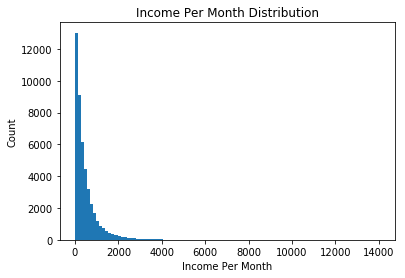

In [77]:
# Let's take a look at the income distribution visually:

plt.hist(data_mf.income,bins=100)
plt.title("Income Per Month Distribution")
plt.xlabel("Income Per Month")
plt.ylabel("Count")
plt.show()

We can see that there are a lot of listings beyond the 75th quartile - 11,402, in fact.
Beyond £4,000, there are 43 listings left. It could be worth removing some of these outliers, but for the purpose of this project, I will keep them.
It's important to be able to predict income regardless of how big or small it is. 
From a production standpoint, if AirBnB used such a model to let new hosts know how much income they may make, it's important to be able to predict high incomes accurately as you'd want them to be eager to join the platform, ready to make lots of money. Thus adding a high-commission listing, and providing more income for AirBnB.



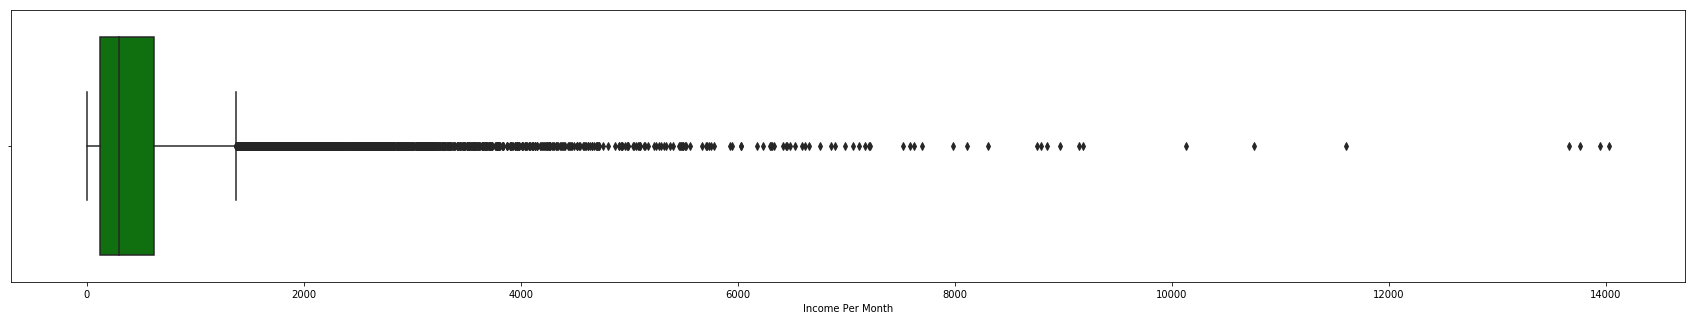

In [78]:
plt.figure(figsize=(30,5))
sns.boxplot(data_mf.income,color='g')
plt.xlabel("Income Per Month")
plt.show()

**Adding Amenities Data**

The original format of the amenities variable was a messy list for each listing. In another notebook, I cleaned this and created binarized columns per amenity (1 for 'has amenity', 0 for 'doesn't have').

In [79]:
# Import Cleaned Amenities File:
amenities_df = pd.read_csv("/Users/bridmcnulty/Desktop/amenities.csv")
amenities_df.drop(columns=['Unnamed: 0'],inplace=True)

# Merge onto main dataframe:
data_mf = data_mf.merge(amenities_df,how='left',on='id')
data_mf.head(2)

,id,experiences_offered,host_id,host_name,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,...,a_self_checkin,a_elevator,a_fireplace,a_dishwasher,a_cats,a_pets_allowed,a_lockbox,a_building_staff,a_pets_on_property,total_amenities
0,13913,business,54730,Alina,within a day,60.0,0,4.0,"['email', 'phone', 'facebook', 'reviews']",1,...,0,0,0,0,0,0,0,0,0,52
1,15400,romantic,60302,Philippa,within a few hours,100.0,0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1,...,0,0,0,0,0,0,0,0,0,22


**Adding Vader Scores From Written Reviews**

From InsideAirBnB.com, I pulled another csv which included all written reviews for each listing. In another notebook, I cleaned this and performed vader sentiment analysis to understand the positive, neutral, negative and compound sentiments behind each. I then averaged scores per listing. This may be helpful to predict income (positive reviews = better income), it will also be interesting to see **how important reviews are**.

Side note: Vader scores are explored in more depth in my Classification notebook, where it's broken down by income classes.

In [80]:
# Import written reviews sentiment analysis file:
sent = pd.read_csv("/Users/bridmcnulty/Desktop/reviews_vader_scores.csv")
sent.head(1)

,listing_id,vader_neg,vader_pos,vader_neu,vader_compound,comment_length
0,9554,0.019522,0.330821,0.649664,0.650421,33.156716


In [81]:
# Merge onto main dataframe
data_mf = data_mf.merge(sent,how='left',left_on='id',right_on='listing_id')
# 9 listings with no sentiment scores => remove them!
data_mf.dropna(inplace=True)

**Adding Vader Scores From Listing Summary & Descriptions**

Similar to the vader scores for written reviews, I analysed the scores for listings summaries and descriptions. These were written by hosts and are displayed at the top of their listing. It may be interesting to see if the sentiment behind what's presented affects income.

Side note: There is word cloud EDA for summaries based on income classes in the Classification notebook.

In [82]:
# Import listing summary and description sentiment analysis file:
summary = pd.read_csv("/Users/bridmcnulty/Desktop/desc_vader.csv")
summary.drop(columns=['Unnamed: 0'],inplace=True)
summary.head(1)

,vader_neu_summary,vader_compound_summary,vader_neg_summary,vader_pos_summary,vader_compound_desc,vader_pos_desc,vader_neg_desc,vader_neu_desc,id
0,0.582,0.9747,0.028,0.39,0.9949,0.284,0.009,0.707,13913


In [83]:
# Merge onto main dataframe
data_mf = data_mf.merge(summary,how='left',on='id')
# 1500 listings with no summary/description sentiment scores => remove them!
data_mf.dropna(inplace=True)

In [84]:
# Created a variable that takes into account a neighbourhood/borough's richness. I'm importing average house prices per borough. Sourced from the London Datastore:
    # This didn't seem to help my models, if anything it worsened them.
#house_prices = pd.read_csv("/Users/bridmcnulty/Desktop/avg_house_price_borough.csv",header='infer')
#house_prices.head(2)

#data_mf = data_mf.merge(house_prices, how="left",left_on="neighbourhood_cleansed",right_on="borough",copy=False)
#data_mf.drop(columns='borough', inplace=True)
#data_mf.head(1)

In [85]:
data_mf.shape

(44105, 174)

**All ready!**
We're left with 44,105 unique listings and 174 features.

# Save Data File Ready to Explore & Model On:

In [86]:
data_mf.to_csv('/Users/bridmcnulty/Desktop/cleaned_data.csv')
# Import it in (so don't need load all above each time)
data_mf = pd.read_csv("/Users/bridmcnulty/Desktop/cleaned_data.csv")
data_mf.drop(columns=['Unnamed: 0'],inplace=True)
data_mf.head(1)

,id,experiences_offered,host_id,host_name,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,...,vader_compound,comment_length,vader_neu_summary,vader_compound_summary,vader_neg_summary,vader_pos_summary,vader_compound_desc,vader_pos_desc,vader_neg_desc,vader_neu_desc
0,13913,business,54730,Alina,within a day,60.0,0,4.0,"['email', 'phone', 'facebook', 'reviews']",1,...,0.752046,88.464286,0.582,0.9747,0.028,0.39,0.9949,0.284,0.009,0.707


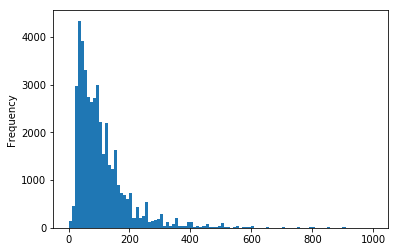

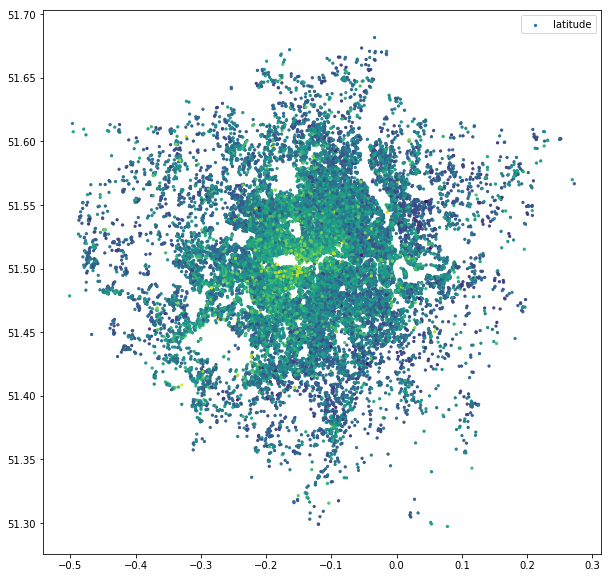

In [206]:
# Investigating location vs price

loc = data_mf[['longitude','latitude','price','income']]
loc['price_log']=loc['price'].apply(np.log) # as otherwise it's too skewed to the left.
loc.price.plot(kind='hist',bins=100)

plt.figure(figsize=(10,10))
plt.scatter(loc.longitude, loc.latitude, c=loc.price_log, s=5)
plt.show()

# Note: More neighbourhood based EDA near bottom of notebook when segmenting models by borough.

**Interactive plot below showing average income per borough**

In [358]:
# From Tableau Online

%%HTML

<script type='text/javascript' src='https://eu-west-1a.online.tableau.com/javascripts/api/viz_v1.js'></script><div class='tableauPlaceholder' style='width: 1254px; height: 705px;'><object class='tableauViz' width='1254' height='705' style='display:none;'><param name='host_url' value='https%3A%2F%2Feu-west-1a.online.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='&#47;t&#47;bridmcnulty' /><param name='name' value='Boroughs_Map_Avg_Income&#47;BoroughAvgIncome' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='showAppBanner' value='false' /><param name='filter' value='iframeSizedToWindow=true' /></object></div>

# Testing Out Different Targets

The aim is to predict income, but first I want to explore some other targets, to try to really understand the strength of the data. I'll look at:

- Predict if host is superhost
- Predict reviews rating score
- Predict price
- Predict occupancy rate
-  Predict reviews per month

In [99]:
def fitter(model, X_train, y_train, X_test, y_test):
    """
    Takes a model, training and test sets as inputs and evaluated the model.
    """
    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)
    print("Train Score: ",model.score(X_train, y_train))
    print("Cross-Val Score: ",cross_val_score(model, X_train, y_train, cv=5).mean())
    print("Test Score: ",model.score(X_test, y_test))
    
def fitter2(model, X_train, y_train, X_test, y_test):
    """
    Takes a model, training and test sets as inputs and evaluated the model and outputs coefficient barchart.
    """
    model.fit(X_train, y_train)
    predictions_test = model.predict(X_test)
    print("Train Score: ",model.score(X_train, y_train))
    print("Cross-Val Score: ",cross_val_score(model, X_train, y_train, cv=5).mean())
    print("Test Score: ",model.score(X_test, y_test))
    df_coef = pd.DataFrame(model.coef_, index=X_train.columns,columns=['coefficients'])
    df_coef['coef_abs'] = df_coef.coefficients.abs()
    df_coef = df_coef.sort_values('coef_abs', ascending=False)

    fix, ax = plt.subplots(ncols=2,figsize=(20,25),sharey=True)
    sns.barplot(df_coef.coef_abs,df_coef.index,ax=ax[0])
    sns.barplot(df_coef.coefficients,df_coef.index,ax=ax[1])
    plt.yticks(fontsize=20)
    plt.tight_layout()
    plt.show()

# 1) Target: Host_is_superhost (78%)

In [296]:
test1 = data_mf[['estimated_monthly_bookings','host_response_time','review_scores_rating','host_response_rate']]

y = data_mf.host_is_superhost
X = pd.get_dummies(test1,drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

lr = LogisticRegression(solver='liblinear', multi_class='ovr',C=20,penalty='l1',max_iter=100)
fitter(lr, X_train, y_train, X_test, y_test)

Train Score:  0.7870307388332848
Cross-Val Score:  0.787095648968404
Test Score:  0.7809854897218863


It's an unsurprisingly good intial result because to be awarded super host status - a host needs:
- A certain amount of bookings per month
- A good response time and rate
- A good review score
- And low cancellation rate (which I don't have)
    
 So the above factors should be able to predict super host status fairly well.

# 2) Target:  Review_Scores_Rating

Just predict review_scores_rating with superhost: 6%
Add in all other review ratings: 75% (as would hope to see!)

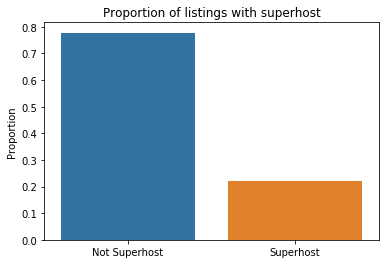

In [322]:
a = pd.DataFrame(data_mf.host_is_superhost.value_counts(normalize=True))
a['Label'] = ['Not Superhost','Superhost']
sns.barplot(y=a.host_is_superhost,x=a.Label)
plt.xlabel("")
plt.ylabel("Proportion")
plt.title("Proportion of listings with superhost")
plt.show()

In [50]:
test2 = data_mf[['review_scores_rating', 'host_is_superhost','income']]

y = test2.pop('review_scores_rating')
X = pd.get_dummies(test2,drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

fitter(lr, X_train, y_train, X_test, y_test)

Train Score:  0.0640509508647561
Cross-Val Score:  0.06400312404684314
Test Score:  0.06213666830395658


Or try predicting review scores based off only host-related predictors:

In [329]:
host_df = pd.DataFrame(data_mf, columns=['host_since_ago','host_response_time','host_response_rate','host_is_superhost',
                                        'host_listings_count','host_has_profile_pic','host_identity_verified','review_scores_rating'])
y = host_df.pop('review_scores_rating')
X = pd.get_dummies(host_df,drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

fitter(lr, X_train, y_train, X_test, y_test)

Train Score:  0.2482104103909565
Cross-Val Score:  0.2483737039155937
Test Score:  0.24886638452237


# 3) Target: Price (57%)

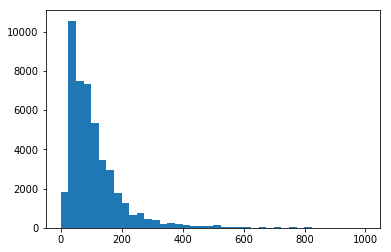

In [64]:
plt.hist(data_mf.price,bins=40)
plt.show()

In [335]:
x = pd.DataFrame(data_mf, columns = ['neighbourhood_cleansed','latitude','longitude','property_type',
                'room_type','accommodates','bathrooms','bedrooms','beds',
'bed_type','first_review_days_ago','host_listings_count','price','tube_proximity','d_british_museum', 'd_tower_london', 'd_covent_garden', 'd_nat_hist_museum', 'd_nat_gallery', 'd_st_pauls'
                                     , 'd_borough_market', 'd_va_museum', 'd_tower_bridge', 'd_westminster_abbey', 'd_churchill_war_room'])

y = x.pop('price')
X = pd.get_dummies(x,drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=2)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

fitter(lr, X_train, y_train, X_test, y_test)

Train Score:  0.5874135653607278
Cross-Val Score:  0.5840972121914852
Test Score:  0.5684835837861185


Not bad start at predicting the price of a listing. Not that helpful though in practice as a host sets their price anyway. It could be useful for AirBnB to suggest prices for new hosts. I.e. Listings like yours price on average £x, with lows of £y and highs of £z

# 4) Target: Occupancy Rate (58%)

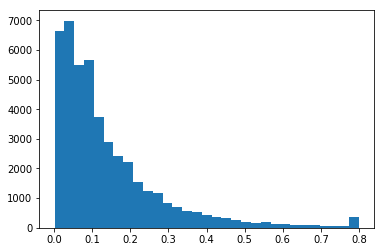

In [66]:
plt.hist(data_mf.capped_or, bins=31)
plt.show()

In [372]:
# Using a combintion of features:
cols_X = ['host_is_superhost','price',
        'neighbourhood_cleansed','tube_proximity','minimum_nights','host_response_rate','host_since_ago',
        'host_listings_count','room_type','host_identity_verified','longitude','accommodates','bathrooms','bedrooms','beds',
        'extra_people','availability_30','availability_60','availability_90','availability_365','number_of_reviews','review_scores_accuracy',
        'review_scores_cleanliness','instant_bookable','require_guest_profile_picture','require_guest_phone_verification',
        'first_review_days_ago','cleaning_fee','experiences_offered'
        ,'total_amenities', 'a_TV', 'a_cable_tv', 'a_kitchen', 'a_family_friendly', 'a_smoking_allowed',
'a_smoke_detector','a_essentials','a_lock_bedroom_door','a_hair_dryer','a_iron' ,'a_laptop_workspace',
'a_outlet_covers','a_childrens_toys','a_crib','a_travel_crib','a_childrens_dinnerware','a_ethernet','a_fridge',
'a_dishes_silverware','a_cooking_basics','a_oven','a_luggage_dropoff','a_long_term_stay_allowed','a_step_free_access',
        'a_accessible_height_bed','a_accessible_height_toilet','a_wide_clearance_to_bed','a_well_lit_entrance',
        'a_smart_lock','a_full_kitchen','a_kettle','a_single_level_home','a_toilet_paper','a_bedroom_comforts',
        'a_bathroom_essentials','a_bath_towel','a_first_aid','a_safety_card','a_internet','a_bbq','a_private_living_room'
        ,'a_private_entrance','a_body_soap','a_24_hour_checkin','a_self_checkin','a_dishwasher','a_building_staff',
          'vader_pos','vader_neg','vader_neu','vader_compound','comment_length']

Train Score:  0.5983134870032518
Cross-Val Score:  0.5944899240367667
Test Score:  0.5760536518728443


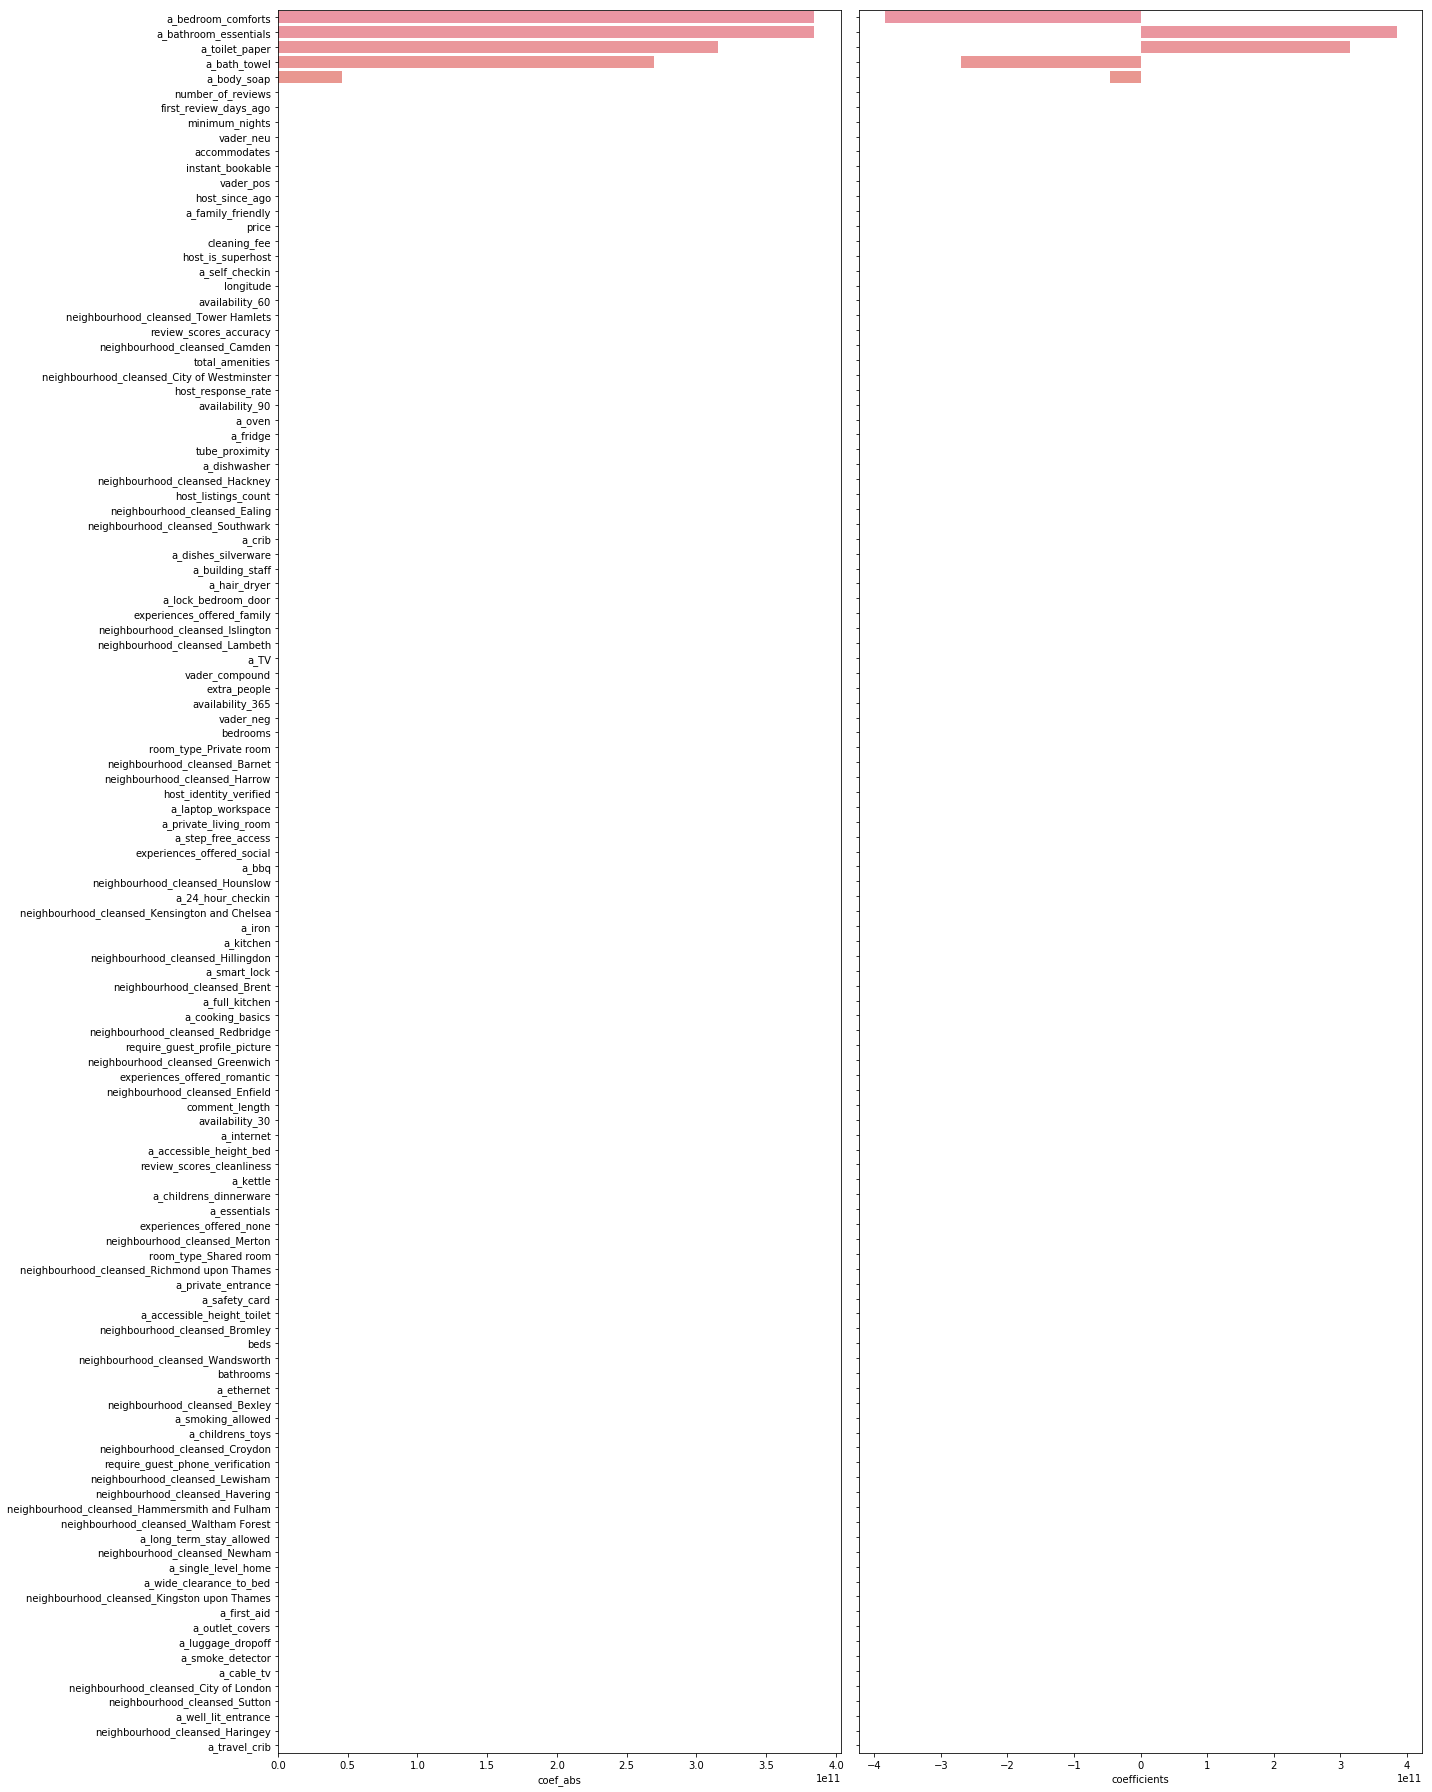

In [373]:
y = data_mf.capped_or
X = pd.get_dummies(data_mf[cols_X],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)


fitter2(lr, X_train, y_train, X_test, y_test)

# 5) Target: Reviews Per Month (58%)

In [374]:
# Predicting reviews_per_month - this would be interesting to model well as reviews_per_month is used in the calculation of occupancy rate.

cols_X = ['host_is_superhost','price',
        'neighbourhood_cleansed','tube_proximity','minimum_nights','maximum_nights',
        'host_response_rate','host_since_ago','host_listings_count','room_type','host_identity_verified',
        'longitude','accommodates','bathrooms','bedrooms','beds',
        'extra_people','availability_30','availability_60',
        'availability_90','availability_365','number_of_reviews','review_scores_accuracy','review_scores_checkin',
                    'review_scores_cleanliness','review_scores_rating','review_scores_value','review_scores_communication',
                     'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',
                    'first_review_days_ago','cleaning_fee','experiences_offered']

Train Score:  0.5791473280650266
Cross-Val Score:  0.5392017294183317
Test Score:  0.581234073400481


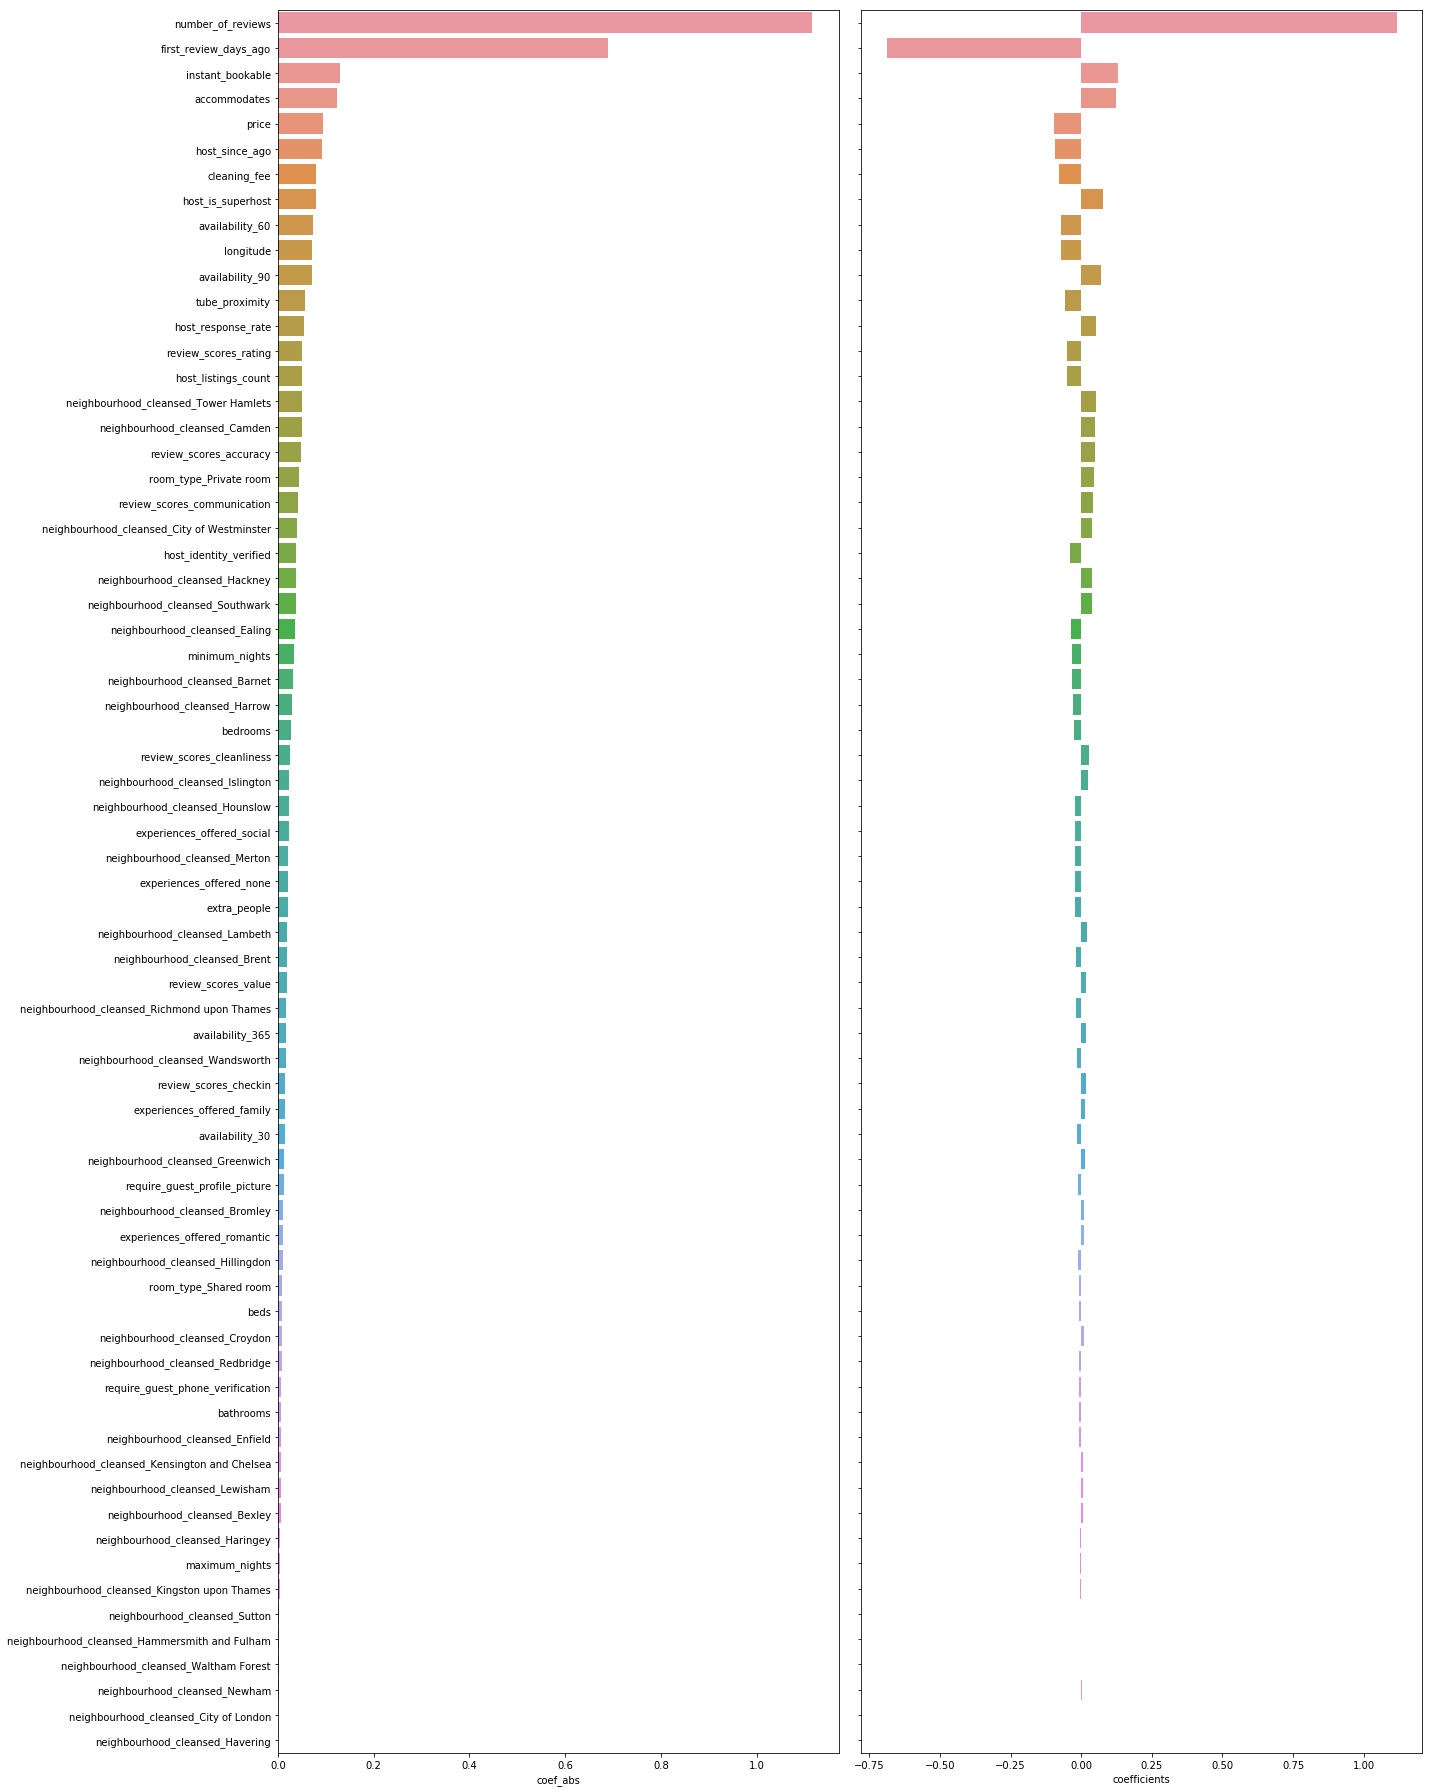

In [375]:
y = data_mf.reviews_per_month
X = pd.get_dummies(data_mf[cols_X],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=10)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

fitter2(lr, X_train, y_train, X_test, y_test)

# PREDICTING INCOME (per month)

I will look at different feature types in predicting income. Then combine feature types, to see which combo will get the best accuracy score.

The Breakdown
1. Just written review sentiment scores 
2. Just location-related features
3. Just amenities
4. Just listing summary and description sentiment scores
5. Just the main features (e.g. beds, bathrooms, host_response_rate etc.)

# 1. Just Review-Related Features (Income): 10%

Most of this result comes from the review ratings predictors. The vader scores didn't contribute much as there is no correlation between any of the vader scores and income.

0.035943115229213764
0.001505404682567668
0.010773047589081356
-0.011105504741502358
Train Score:  0.08345096250099071
Cross-Val Score:  0.08206276958051568
Test Score:  0.08567850512626785


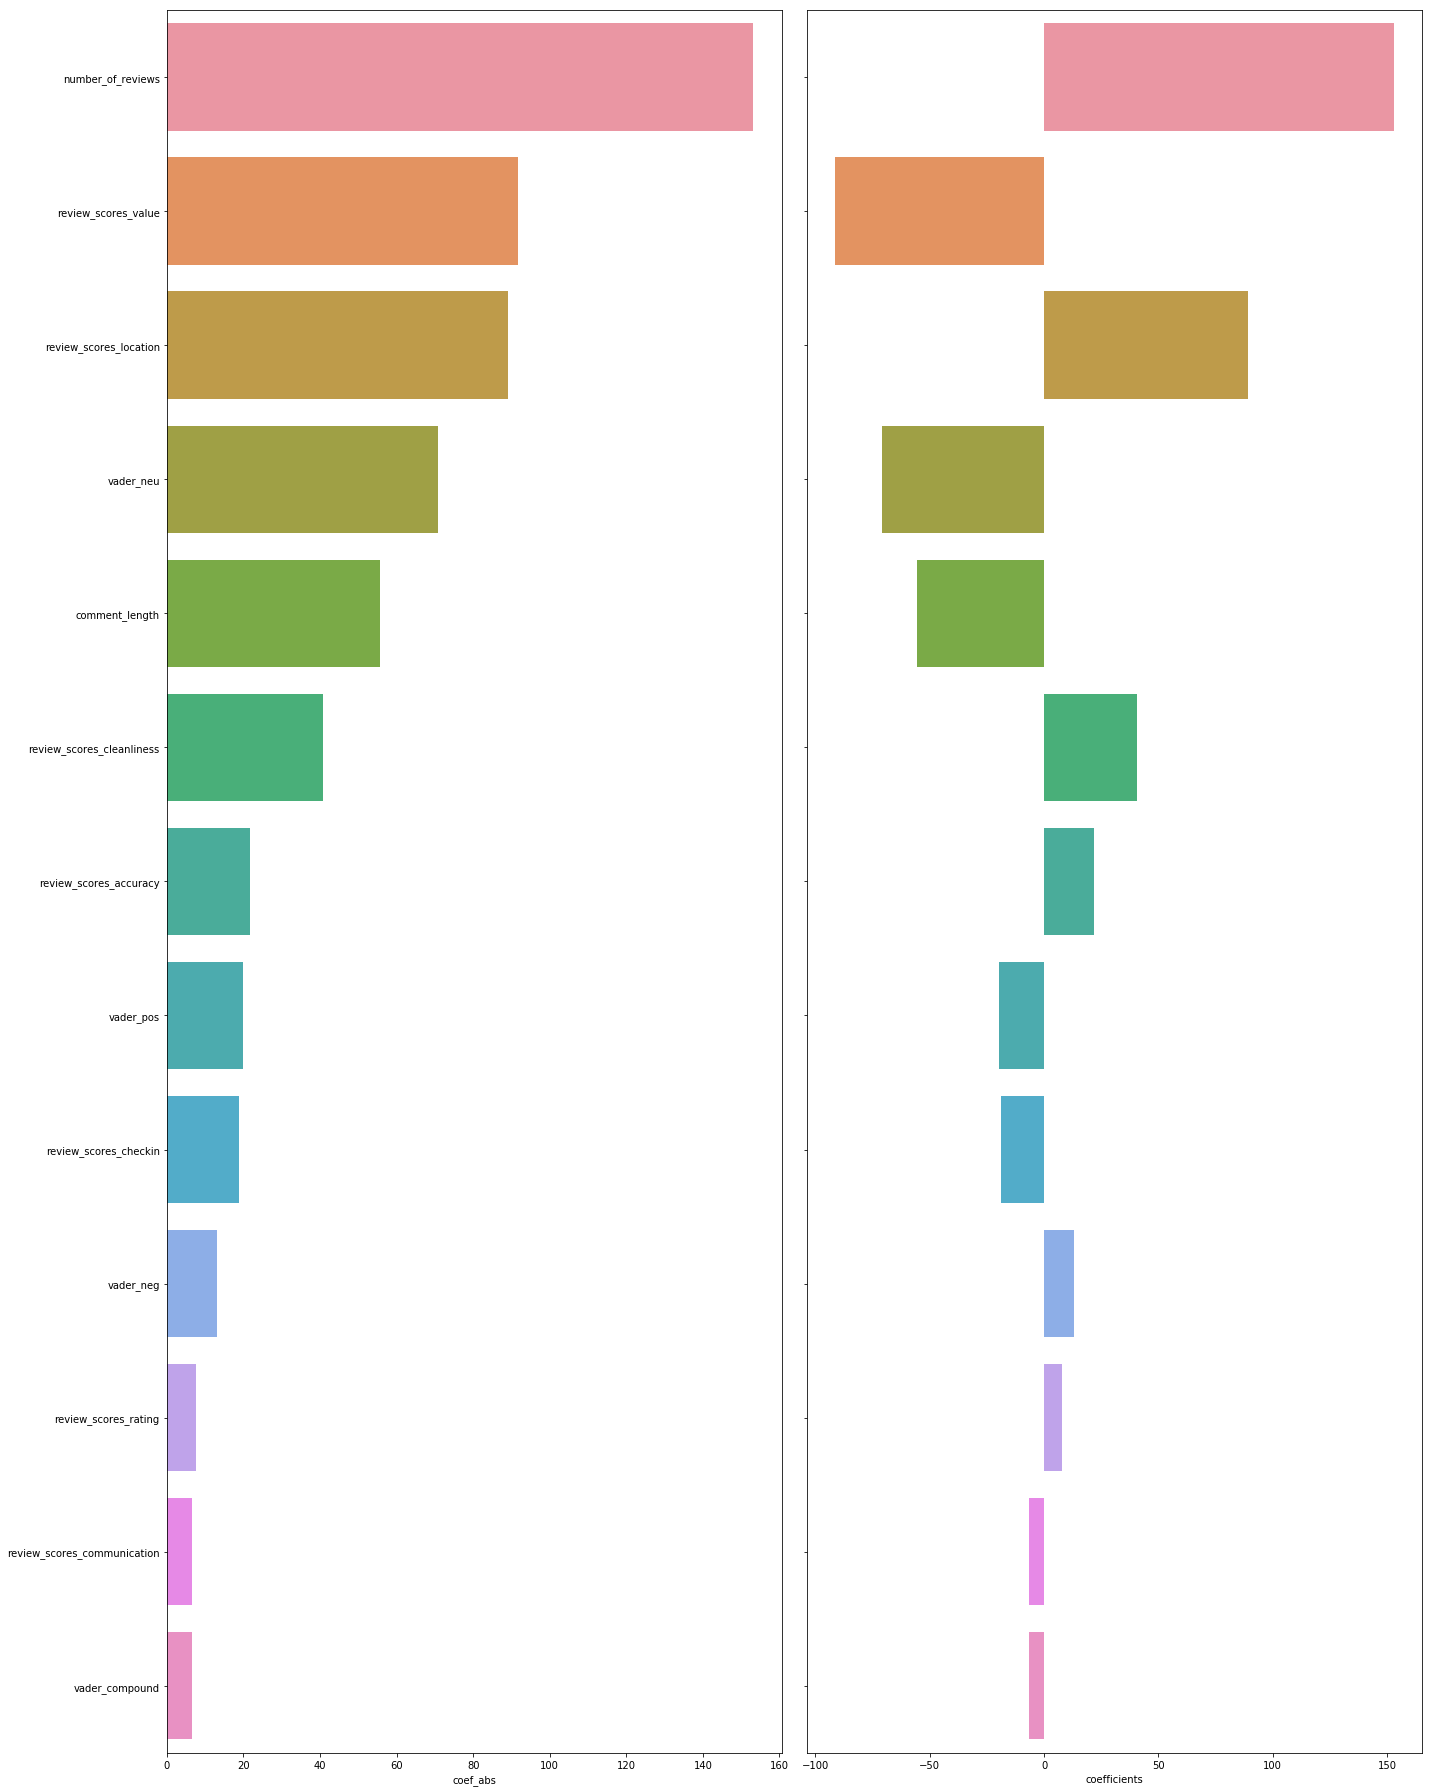

In [52]:
cols_X = ['review_scores_rating','review_scores_accuracy','review_scores_checkin','review_scores_communication',
          'review_scores_value','review_scores_location','review_scores_cleanliness','number_of_reviews',
          'vader_pos','vader_neg','vader_neu','vader_compound','comment_length']

y = data_mf.income
X = pd.get_dummies(data_mf[cols_X],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)


print(data_mf.review_scores_rating.corr(data_mf.vader_compound))
print(data_mf.review_scores_rating.corr(data_mf.vader_neg))
print(data_mf.review_scores_rating.corr(data_mf.vader_pos))
print(data_mf.review_scores_rating.corr(data_mf.vader_neu))
fitter2(lr, X_train, y_train, X_test, y_test)

# 2. Just Location-Related Features (Income): 11%

Location-related features alone predict income fairly well, considering how much variation goes on between listings asides from their location. These features includes the borough, proximity to closest tube station, proximity to 11 of London's top attractions, and the listing's latitude and longitude.

Train Score:  0.10297409943576963
Cross-Val Score:  0.10040931196042091
Test Score:  0.11046763170159046


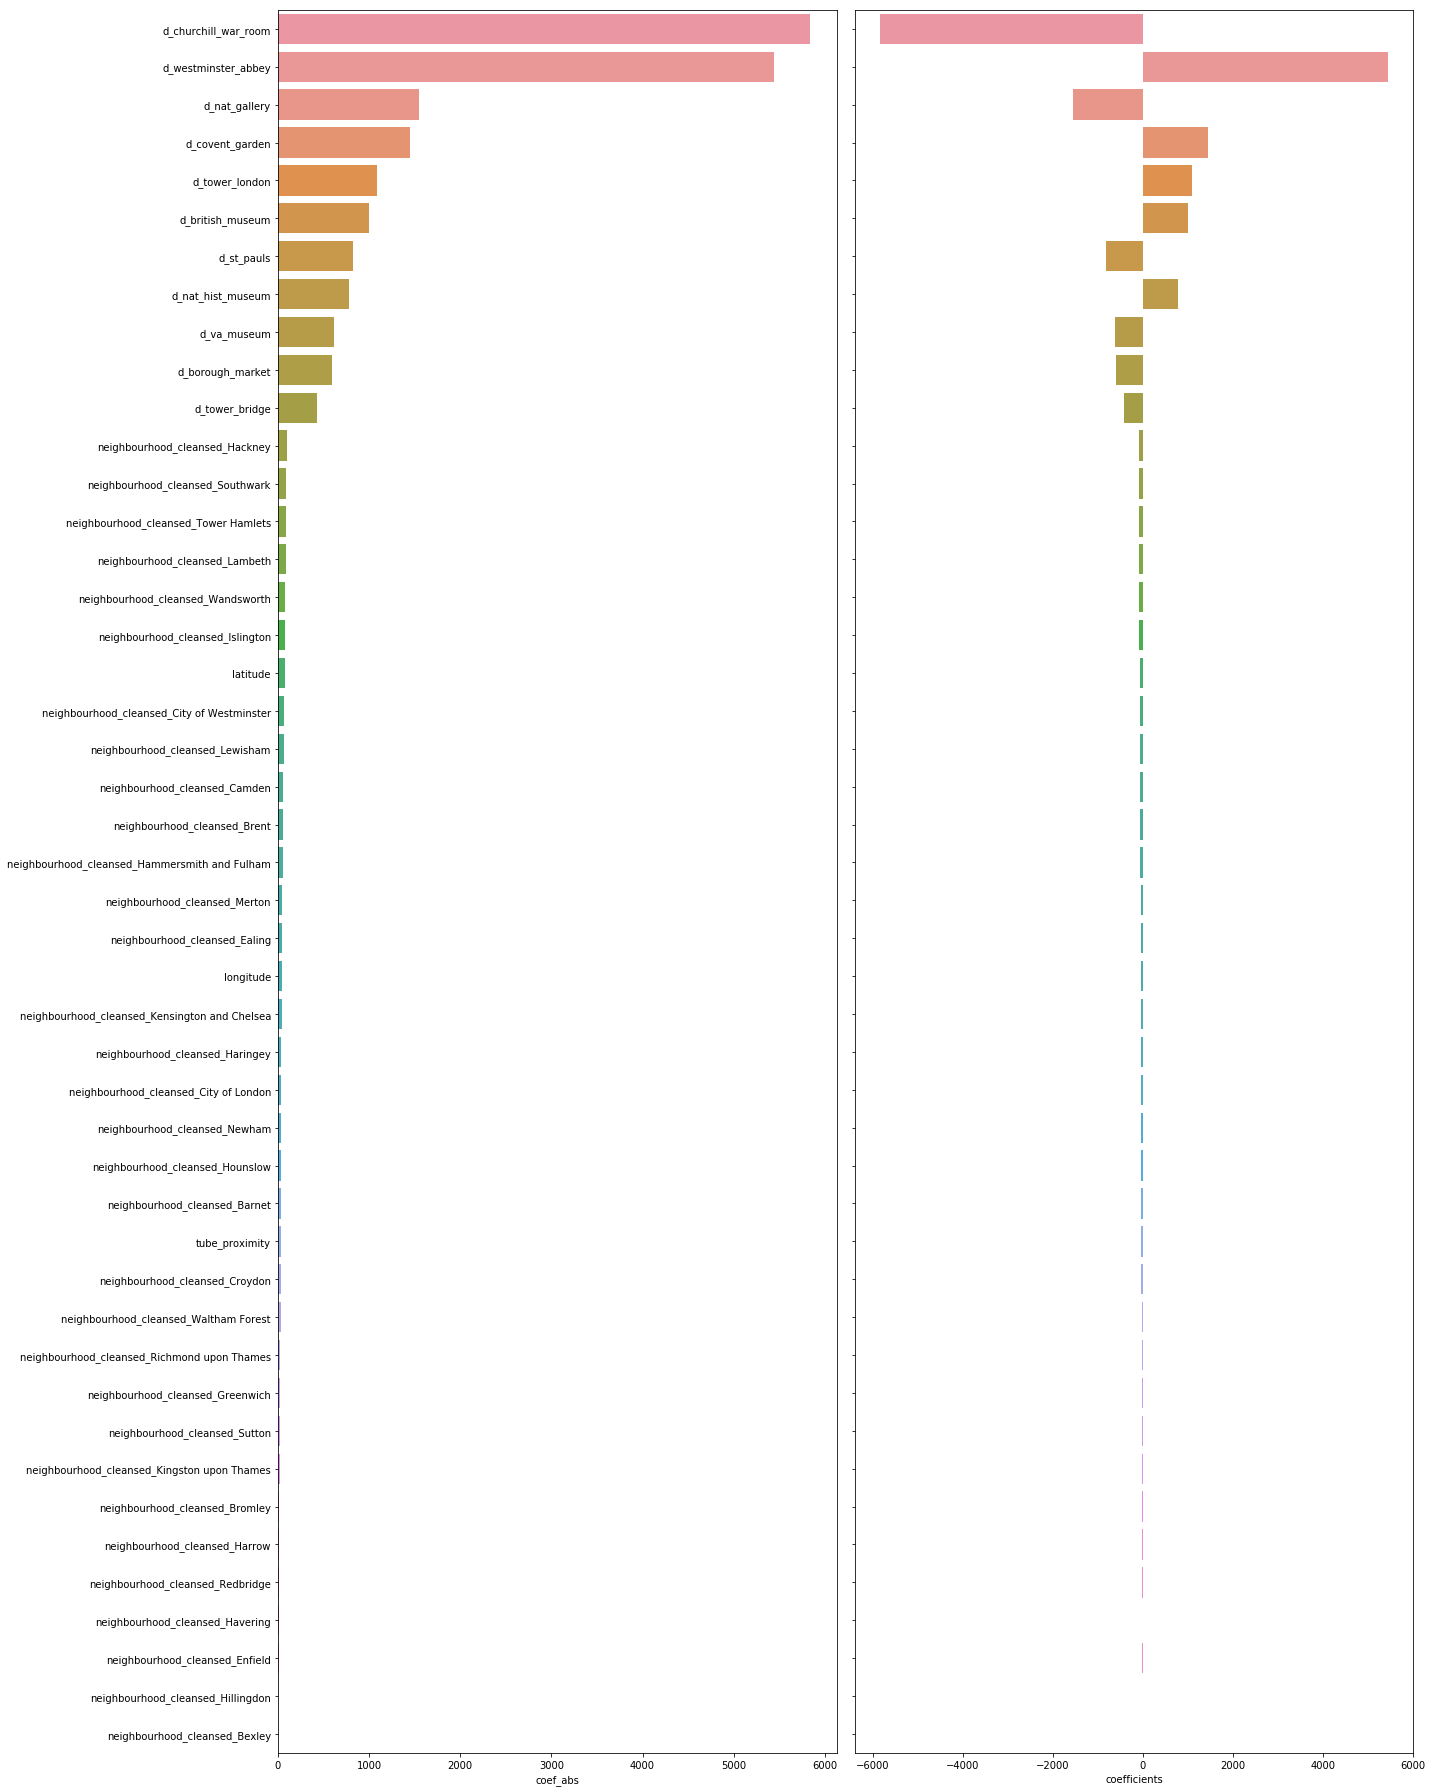

In [53]:
# How well does location predict income

y = data_mf.income
X = pd.get_dummies(data_mf[['neighbourhood_cleansed','tube_proximity',
        'd_british_museum', 'd_tower_london', 'd_covent_garden', 'd_nat_hist_museum', 'd_nat_gallery', 'd_st_pauls', 'd_borough_market', 'd_va_museum',
        'd_tower_bridge', 'd_westminster_abbey', 'd_churchill_war_room','latitude','longitude']],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

lr.fit(X_train,y_train)
fitter2(lr, X_train, y_train, X_test, y_test)

Train Score:  0.09388741469706408
Cross-Val Score:  0.09279082333804889
Test Score:  0.10319344665708274


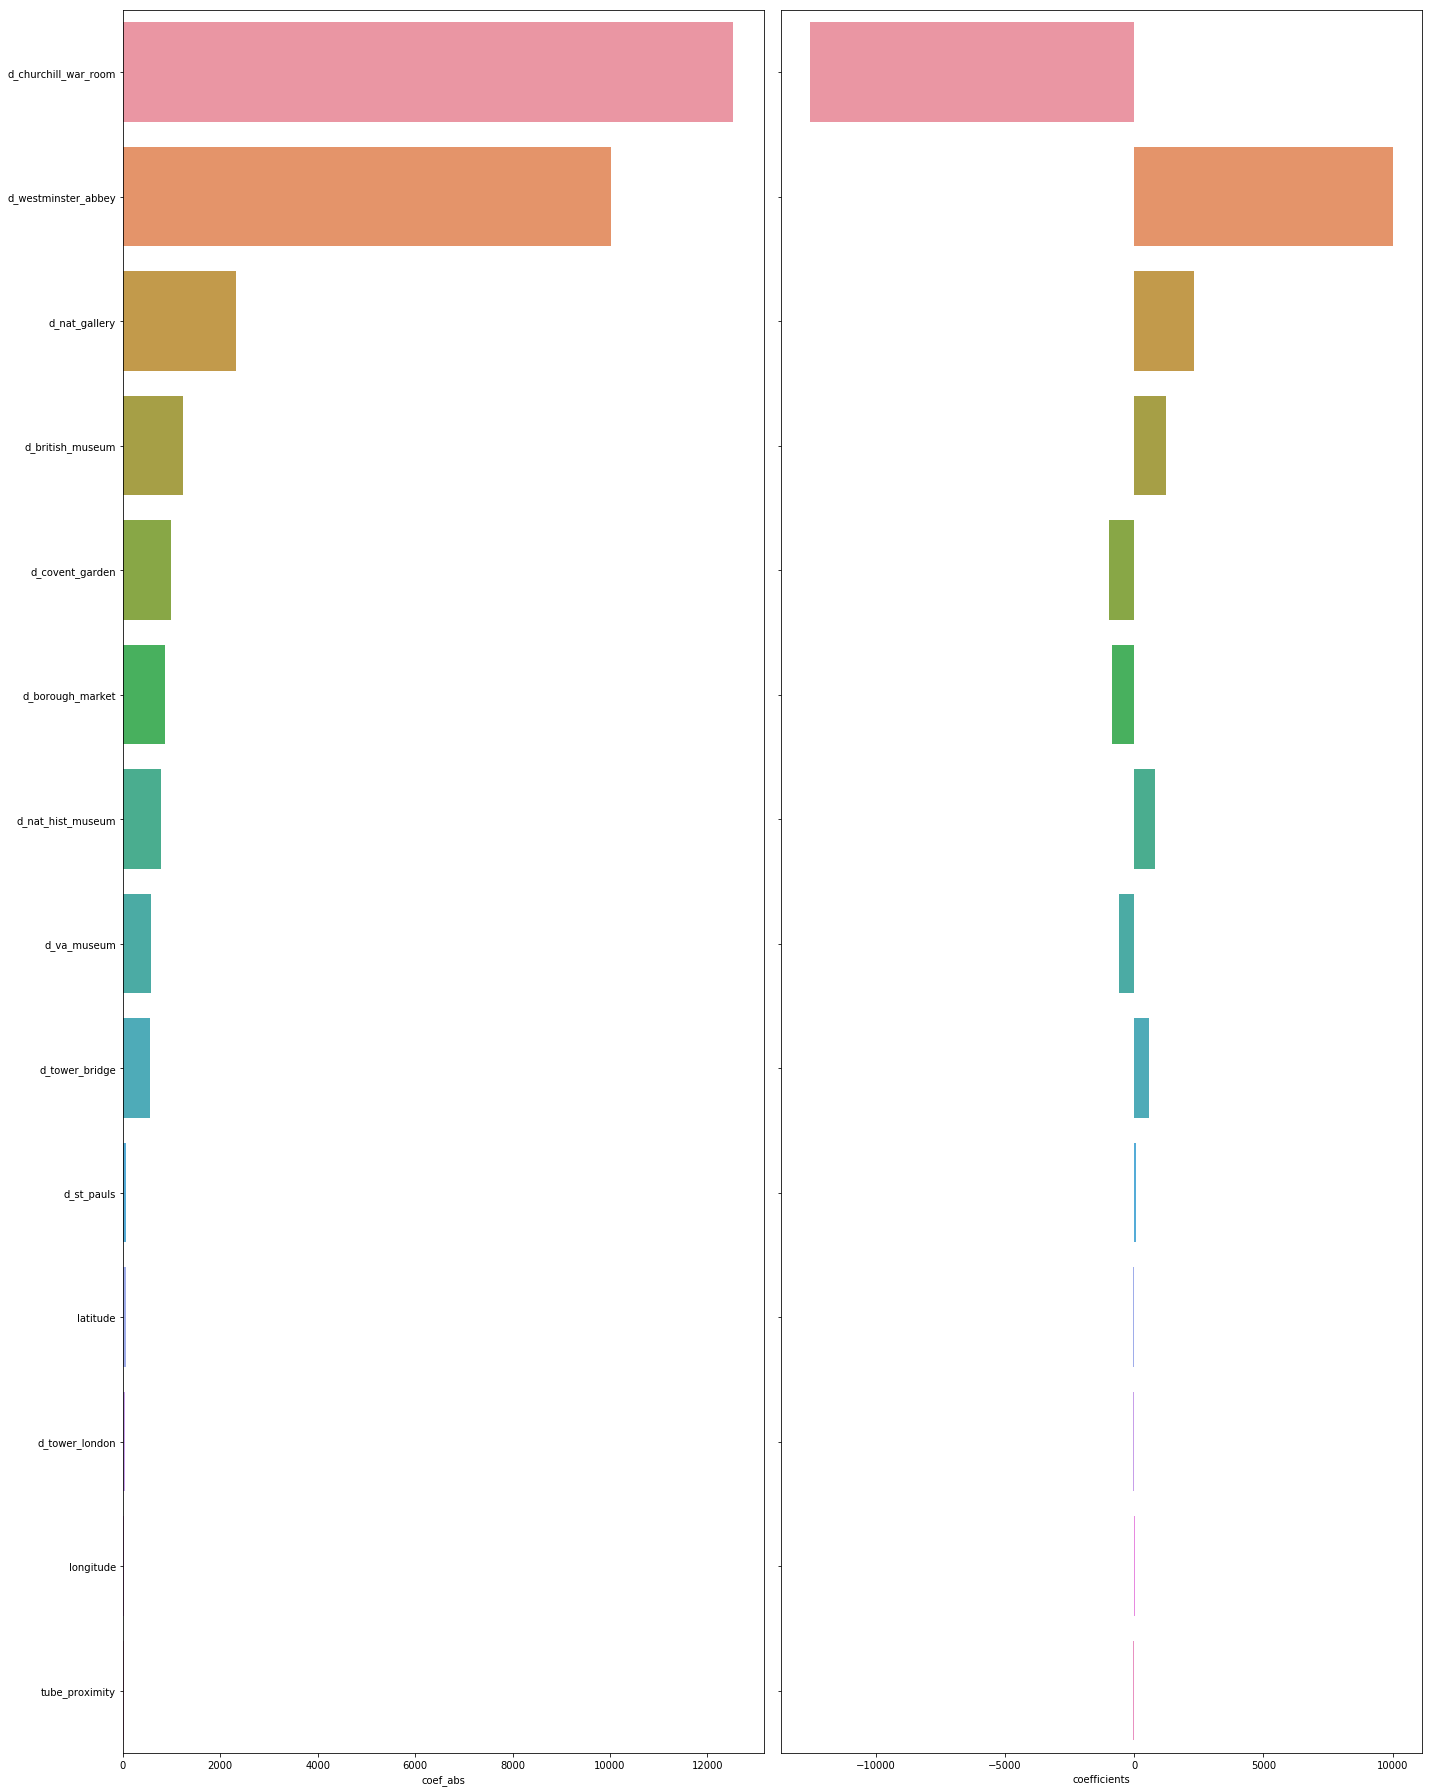

In [54]:
# How well does location predict income (WITHOUT borough)

y = data_mf.income
X = pd.get_dummies(data_mf[['tube_proximity',
        'd_british_museum', 'd_tower_london', 'd_covent_garden', 'd_nat_hist_museum', 'd_nat_gallery', 'd_st_pauls', 'd_borough_market', 'd_va_museum',
        'd_tower_bridge', 'd_westminster_abbey', 'd_churchill_war_room','latitude','longitude']],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

fitter2(lr, X_train, y_train, X_test, y_test)

# 3. Just Amenities (Income): 14%

In another notebook, I've cleaned the amenities variable and binarized for every amenity. Also included a column for total number of amenities per listing.

Amenities alone also predicts income alright. There are a lot of them though, and only a few have significant impact on income. Later, I will go through the list and check which impact model accuracy most, and discard the rest.

In [55]:
amen_cols = [col for col in data_mf.columns if col.startswith('a_')]
amen_cols.append('total_amenities')
print(amen_cols)

['a_wifi', 'a_TV', 'a_cable_tv', 'a_kitchen', 'a_paid_parking_off_premises', 'a_smoking_allowed', 'a_free_street_parking', 'a_buzzer_intercom', 'a_heating', 'a_family_friendly', 'a_washer', 'a_dryer', 'a_smoke_detector', 'a_carbon_monoxide_detector', 'a_fire_extinguisher', 'a_essentials', 'a_shampoo', 'a_lock_bedroom_door', 'a_hangers', 'a_hair_dryer', 'a_iron', 'a_laptop_workspace', 'a_outlet_covers', 'a_bath', 'a_childrens_toys', 'a_babysitter_recs', 'a_crib', 'a_travel_crib', 'a_room_darkening_shades', 'a_childrens_dinnerware', 'a_hot_water', 'a_bed_linens', 'a_extra_pillows', 'a_ethernet', 'a_coffee_maker', 'a_fridge', 'a_dishes_silverware', 'a_cooking_basics', 'a_oven', 'a_stove', 'a_patio_balcony', 'a_luggage_dropoff', 'a_long_term_stay_allowed', 'a_step_free_access', 'a_wide_doorway', 'a_accessible_height_bed', 'a_bath_w_bath_chair', 'a_accessible_height_toilet', 'a_host_greets_you', 'a_handheld_shower_head', 'a_wide_clearance_to_bed', 'a_roll_in_shower', 'a_high_chair', 'a_well

Train Score:  0.1368870020683336
Cross-Val Score:  0.12978570274179643
Test Score:  0.14419162615584846


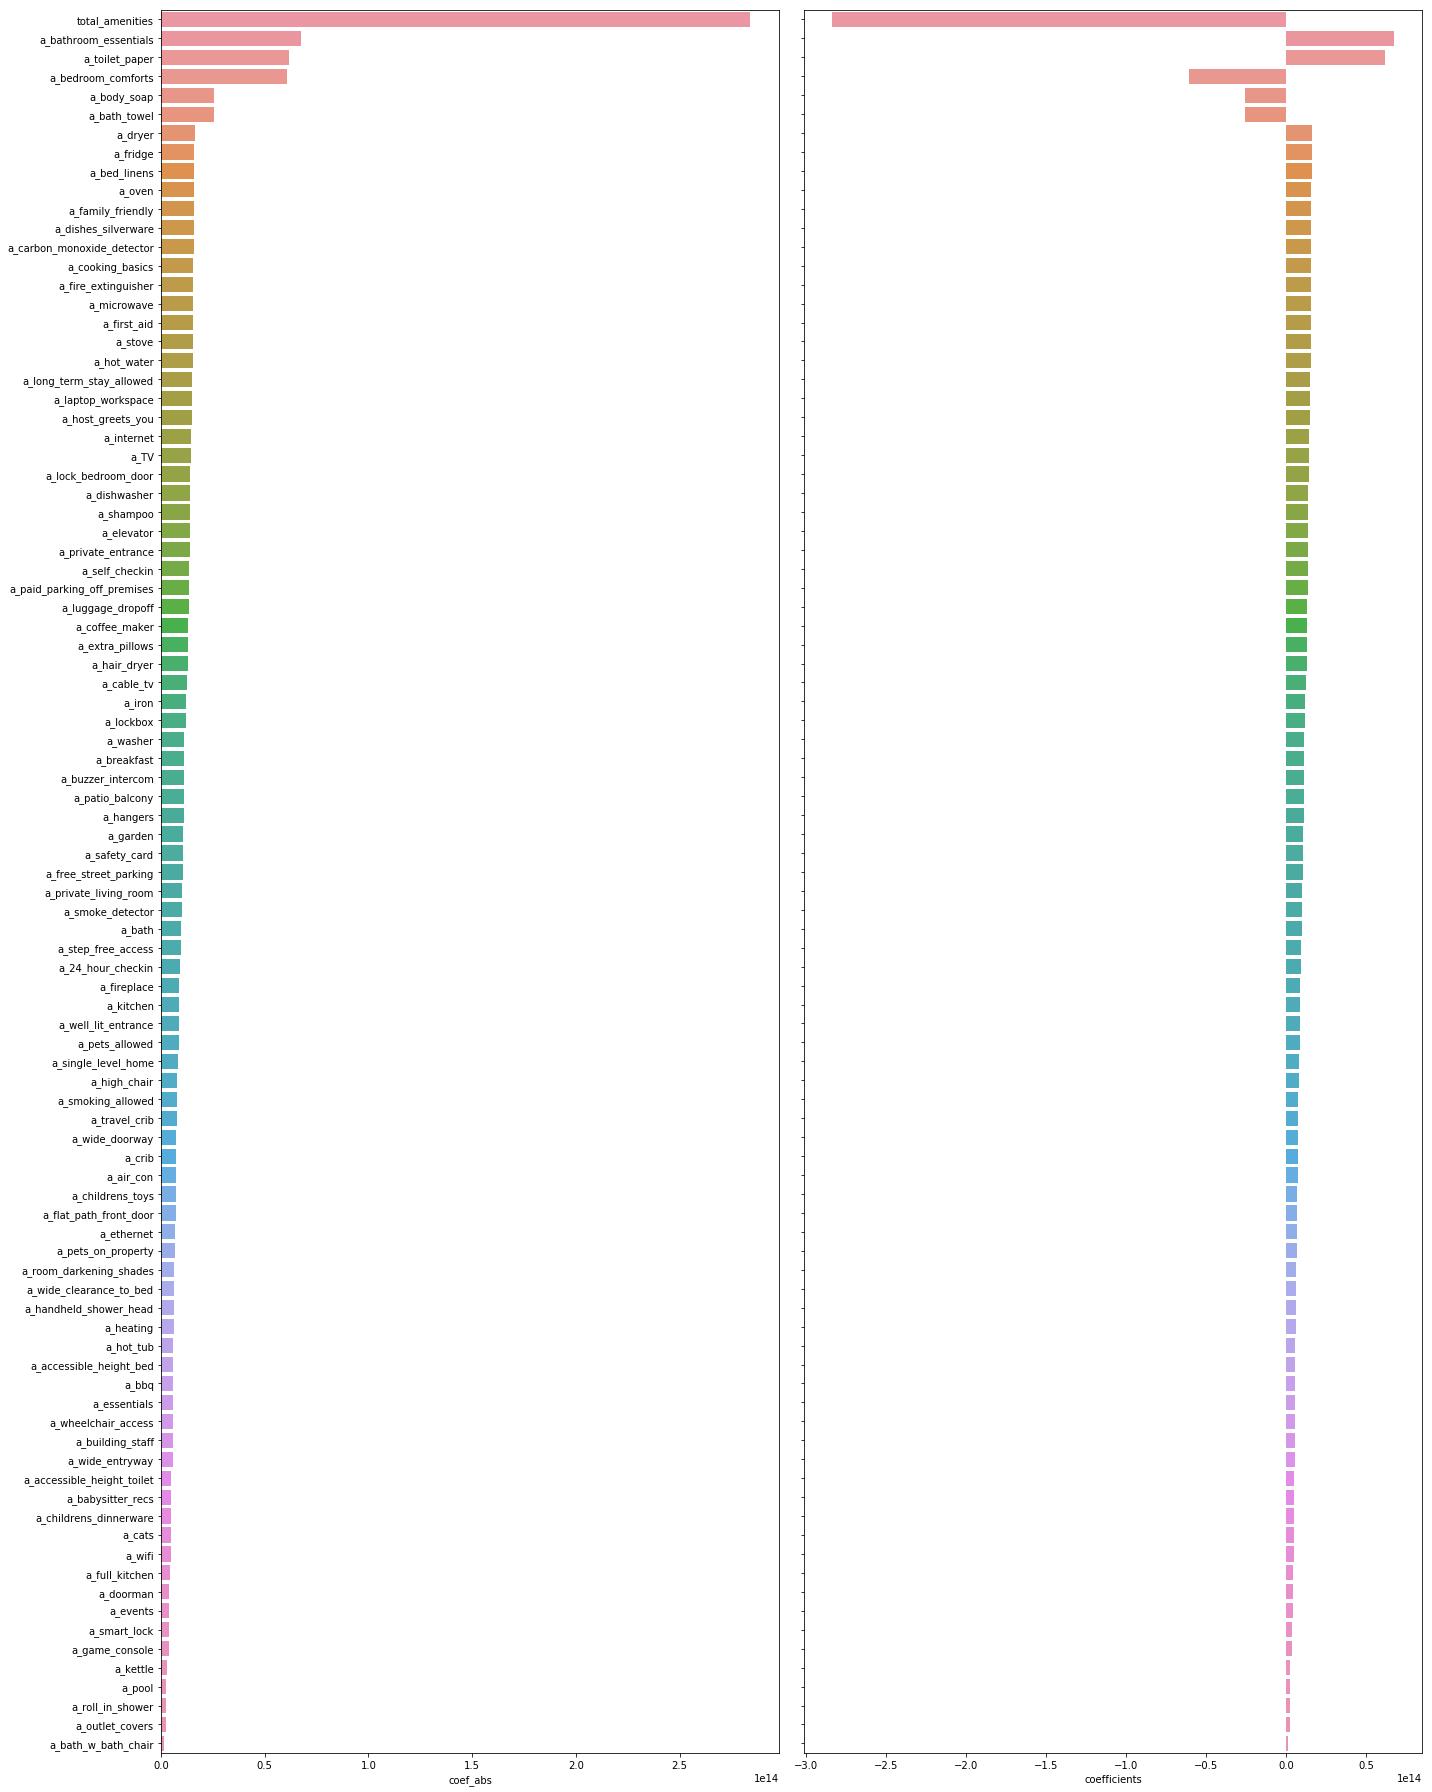

In [56]:
y = data_mf.income
X = data_mf[amen_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

fitter2(lr, X_train, y_train, X_test, y_test)

# 4. Just Summary & Description Sentiment Scores (Income): 0.2%

The sentiment behind a listing summary / description seems to have little impact on income.

From the feature importance plots below, it does show, though, that a more positive description leads to more income. While it seems a more neutral summary is better. 

Train Score:  0.0028108945085841826
Cross-Val Score:  0.002281076411372207
Test Score:  0.0026123711884246115


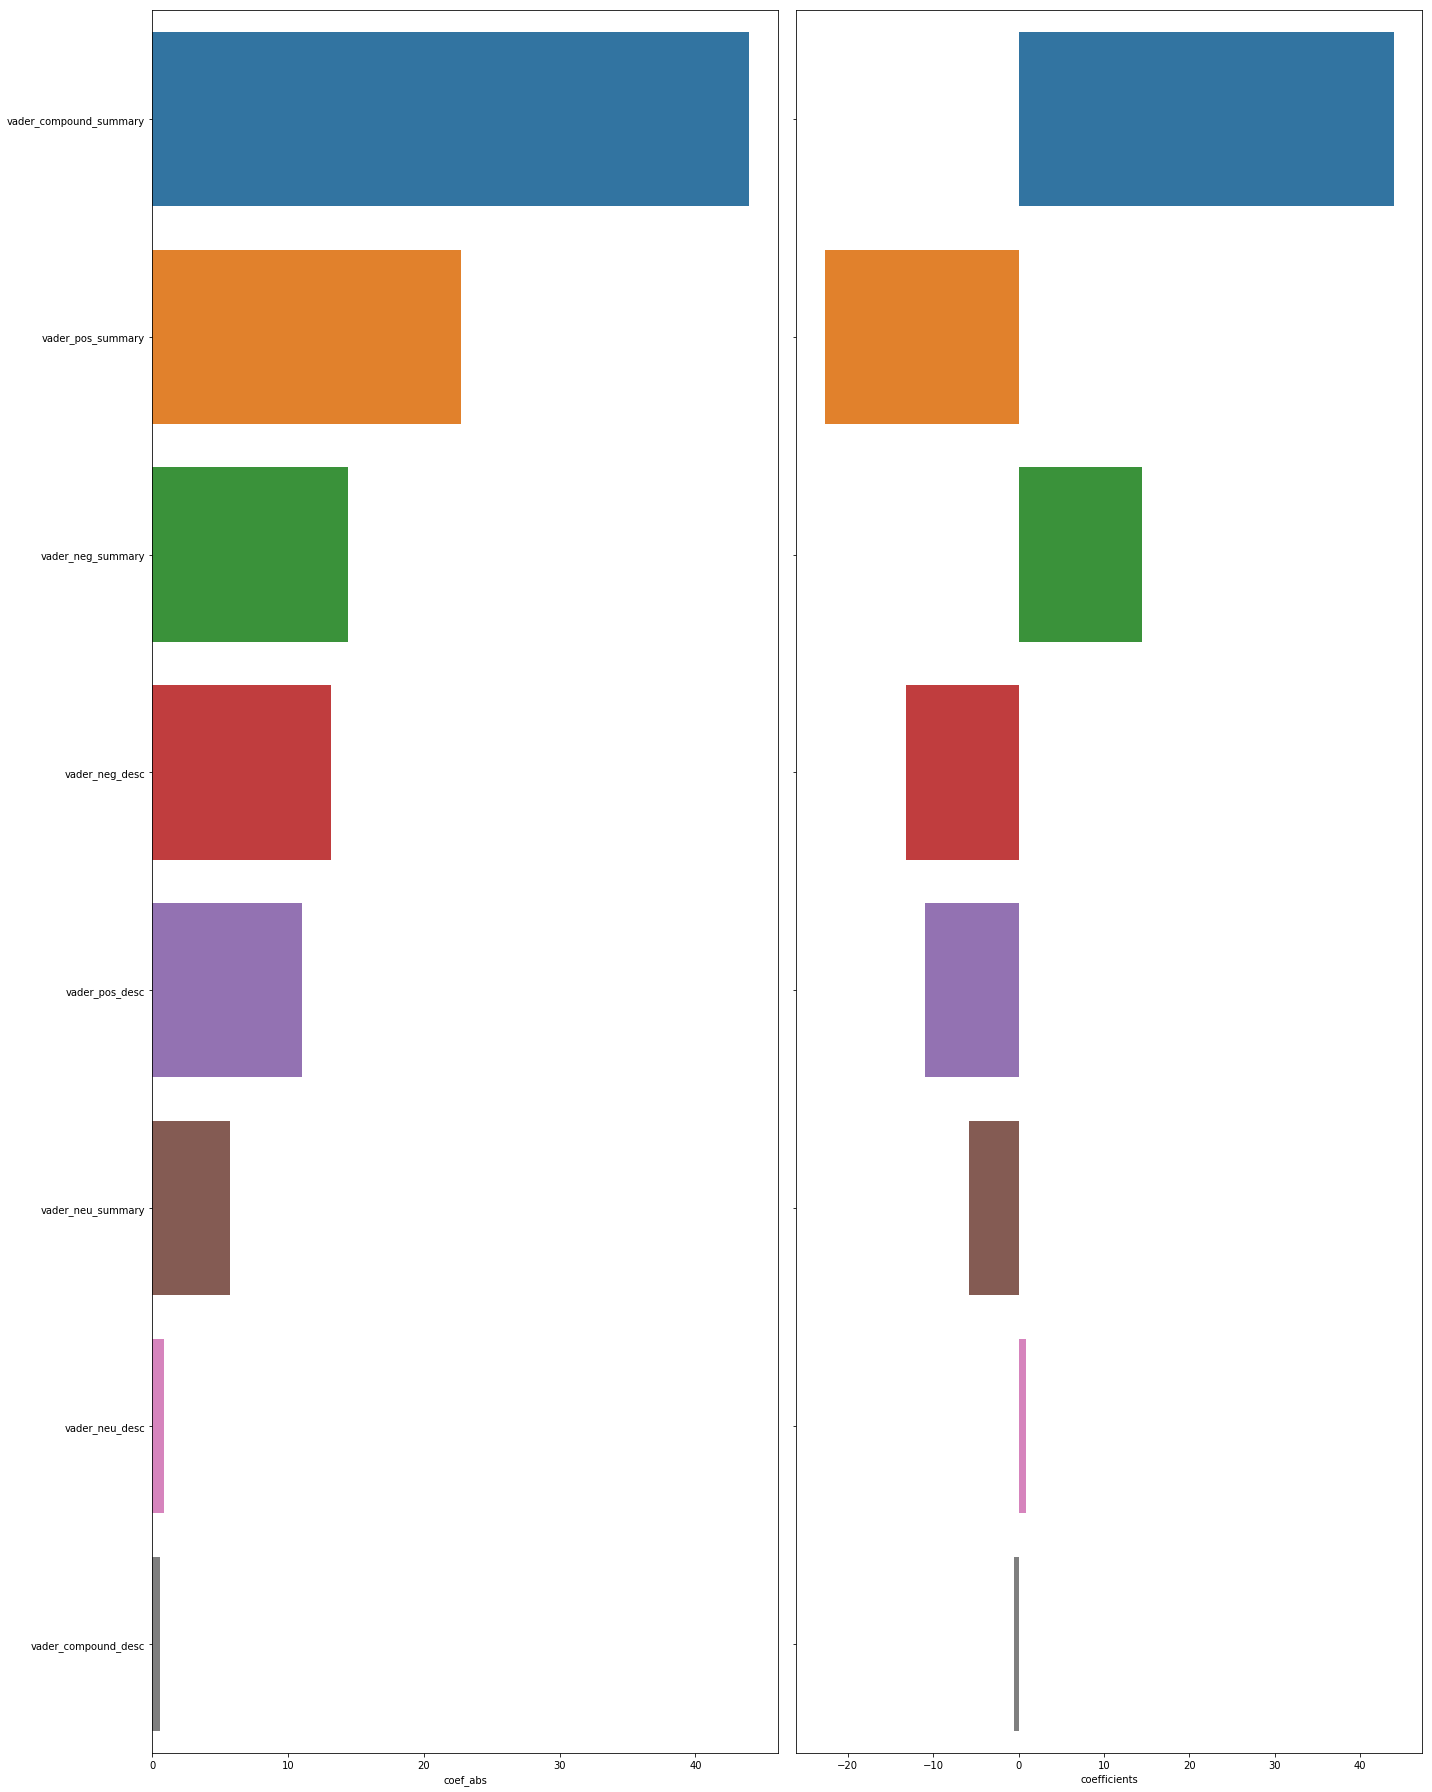

In [57]:
vaders = ['vader_pos_desc','vader_neg_desc','vader_neu_desc','vader_compound_desc',
         'vader_pos_summary','vader_neg_summary','vader_neu_summary','vader_compound_summary']
y = data_mf.income
X = data_mf[vaders]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

fitter2(lr, X_train, y_train, X_test, y_test)

# 5. Just Main Features (Income): 68%

If including features like price, cleaning_fee, minimum_nights etc (those used in the formulation of income,
the model has 68% accuracy. Removing all of those, the model is terrible!

In [370]:
print(data_mf.availability_30.corr(data_mf.availability_60))
print(data_mf.availability_30.corr(data_mf.availability_90))
print(data_mf.availability_30.corr(data_mf.availability_365))
# Just use availability_30 and availability_365 - as the others all very correlated. This could lead to a worsened model.
# availability_60 and 90 don't add much more value in a different way than 30.

0.9247953915707479
0.8585170089929863
0.5177952998056965


In [376]:
print(data_mf.beds.corr(data_mf.bedrooms))
print(data_mf.bedrooms.corr(data_mf.bathrooms))
print(data_mf.accommodates.corr(data_mf.beds))

# accommodates and beds are very correlated. Neither are VERY correlated to the target (aka neither are GREAT hints).
    # Omit 'beds'

#The keyword being harmful. If you have correlated features but they are also correlated 
#to the target, you want to keep them. You can view features as hints to make a good guess, 
#if you have two hints that 
#are essentially the same, but they are good hints, it may be wise to keep them.

#If your model needs to be interpretable, you might be forced to make it simpler. Make sure to also remember Occam's razor. 
#If your model is not "that much" worse with less features, then you should probably use less features.

0.7017942899875169
0.5587616219125322
0.8159610432343141


In [377]:
print(data_mf.beds.corr(data_mf.capped_or_income))
print(data_mf.bedrooms.corr(data_mf.capped_or_income))
print(data_mf.accommodates.corr(data_mf.capped_or_income))

0.25984261680169135
0.23730138232377349
0.36580186183913843


Train Score:  0.6833693832527057
Cross-Val Score:  -9.64621747866674e+21
Test Score:  0.6916110371157502


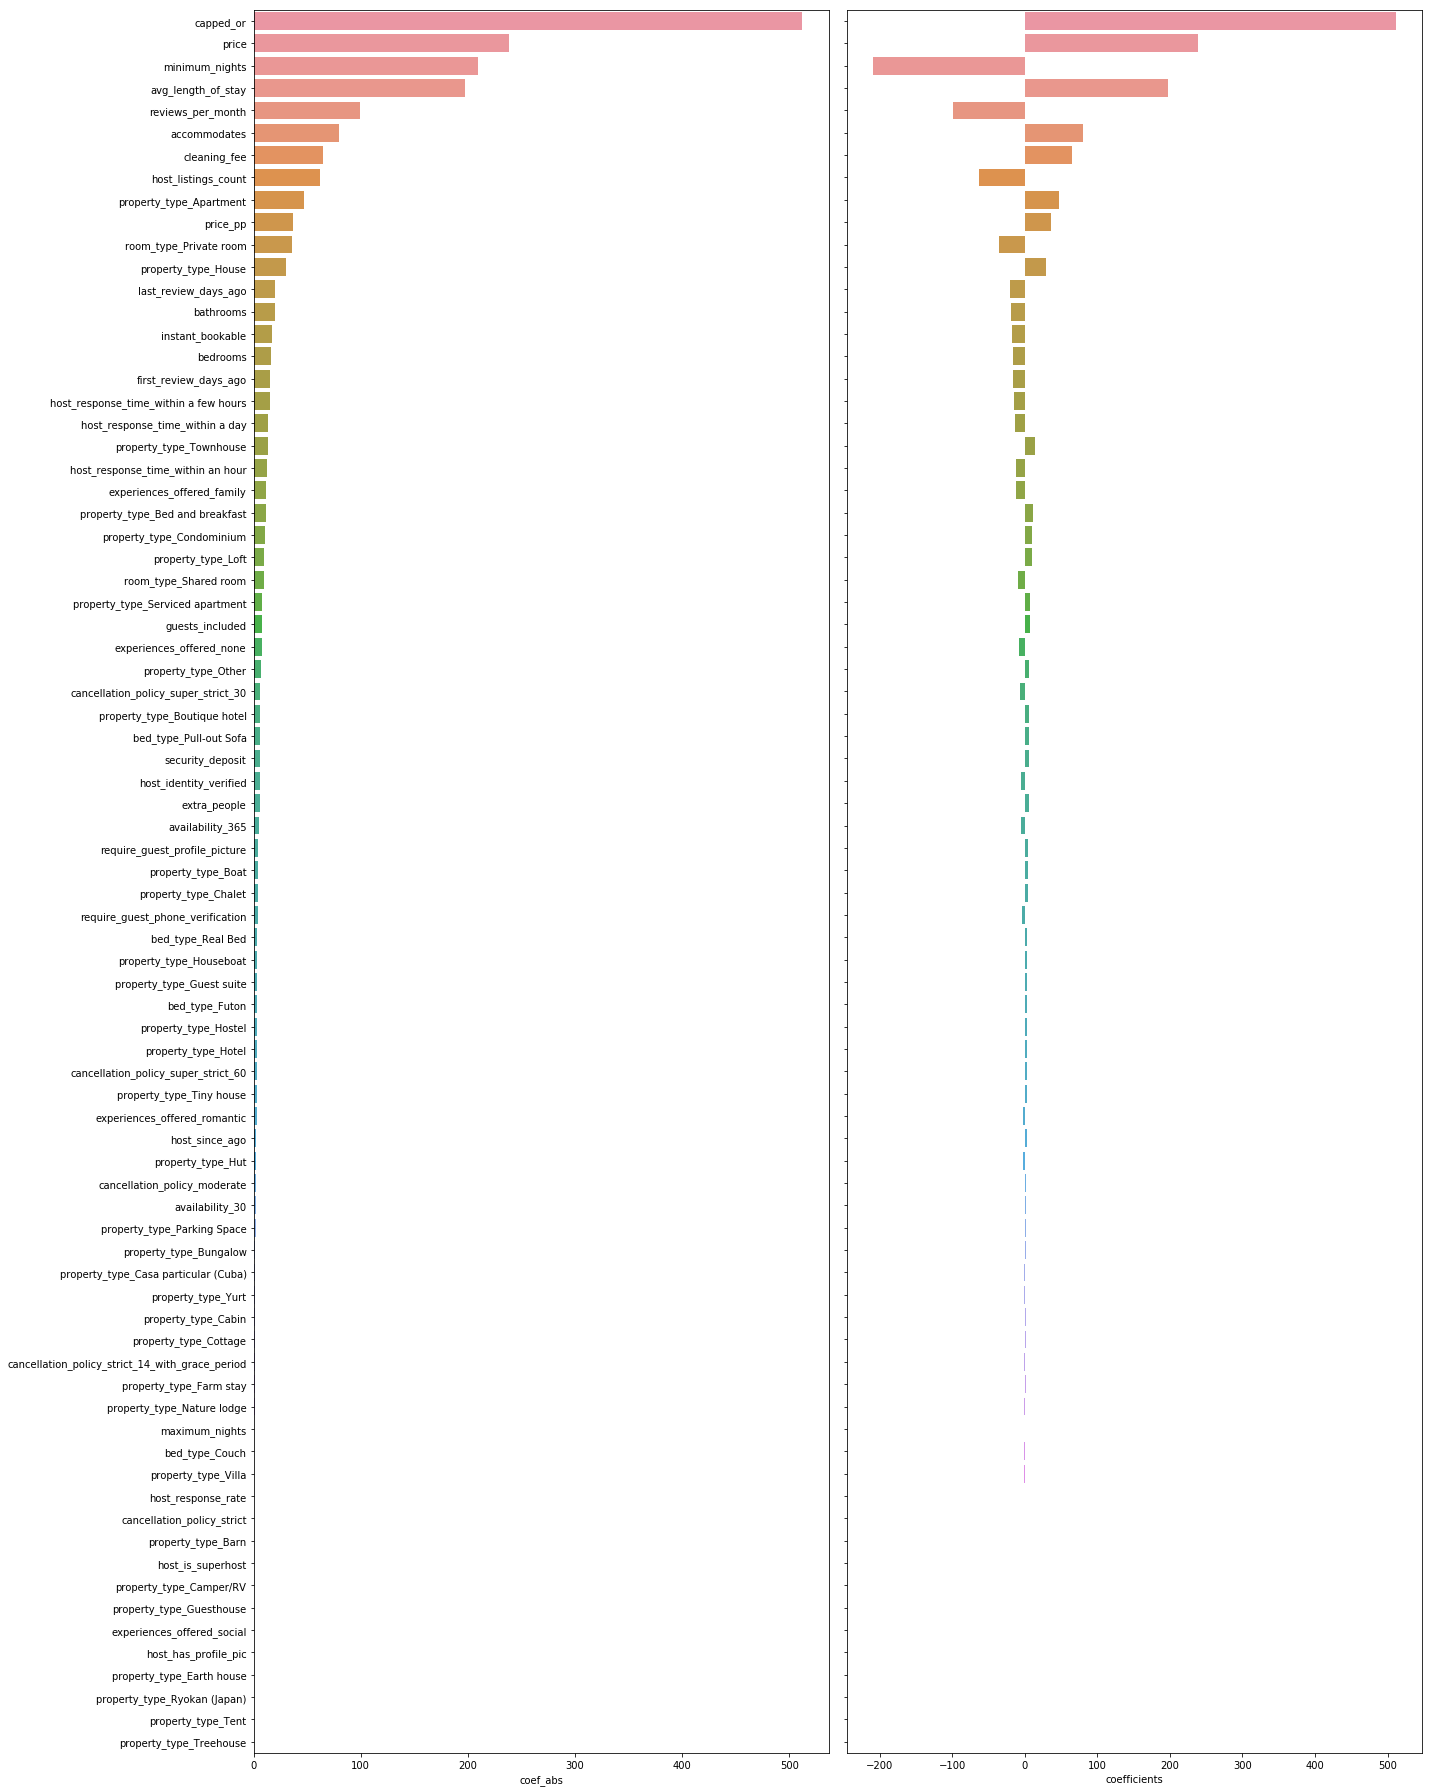

In [58]:
# Including any features related to the calculation of income:
main_feats=['reviews_per_month', 'price','cleaning_fee','minimum_nights','avg_length_of_stay','price_pp','capped_or',
           'host_is_superhost', 'security_deposit','host_response_rate','host_response_time','host_since_ago',
'host_listings_count','room_type','host_has_profile_pic','host_identity_verified','property_type','accommodates',
'bathrooms','bedrooms','guests_included','extra_people','maximum_nights','availability_30','availability_365',
'instant_bookable','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification',
'first_review_days_ago','last_review_days_ago','bed_type' ,'experiences_offered']

y = data_mf.income
X = pd.get_dummies(data_mf[main_feats],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

fitter2(lr, X_train, y_train, X_test, y_test)

# Finding The Best Combo (Income)

1. Put ALL features together
2. All except summary vader scores
3. Main features + one of each 
4. All except main features

In [101]:
# 1. ALL features! TERRIBLE! TOO MANY!:
main_feats=['reviews_per_month', 'price','cleaning_fee','minimum_nights','avg_length_of_stay','capped_or',
           'host_is_superhost', 'security_deposit','host_response_rate','host_response_time','host_since_ago',
'host_listings_count','room_type','host_has_profile_pic','host_identity_verified','property_type','accommodates',
'bathrooms','bedrooms','guests_included','extra_people','maximum_nights','availability_30','availability_365',
'instant_bookable','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification',
'first_review_days_ago','last_review_days_ago','bed_type' ,'experiences_offered',
           'review_scores_rating','review_scores_accuracy','review_scores_checkin','review_scores_communication',
          'review_scores_value','review_scores_location','review_scores_cleanliness','number_of_reviews',
          'vader_pos','vader_neg','vader_neu','vader_compound','comment_length',
           'neighbourhood_cleansed','tube_proximity',
        'd_british_museum', 'd_tower_london', 'd_covent_garden', 'd_nat_hist_museum', 'd_nat_gallery', 'd_st_pauls', 'd_borough_market', 'd_va_museum',
        'd_tower_bridge', 'd_westminster_abbey', 'd_churchill_war_room','latitude','longitude',
           'a_wifi', 'a_TV', 'a_cable_tv', 'a_kitchen', 'a_paid_parking_off_premises', 'a_smoking_allowed', 'a_free_street_parking', 'a_buzzer_intercom', 'a_heating', 'a_family_friendly', 'a_washer', 'a_dryer', 'a_smoke_detector', 'a_carbon_monoxide_detector', 'a_fire_extinguisher', 'a_essentials', 'a_shampoo', 'a_lock_bedroom_door', 'a_hangers', 'a_hair_dryer', 'a_iron', 'a_laptop_workspace', 'a_outlet_covers', 'a_bath', 'a_childrens_toys', 'a_babysitter_recs', 'a_crib', 'a_travel_crib', 'a_room_darkening_shades', 'a_childrens_dinnerware', 'a_hot_water', 'a_bed_linens', 'a_extra_pillows', 'a_ethernet', 'a_coffee_maker', 'a_fridge', 'a_dishes_silverware', 'a_cooking_basics', 'a_oven', 'a_stove', 'a_patio_balcony', 'a_luggage_dropoff', 'a_long_term_stay_allowed', 'a_step_free_access', 'a_wide_doorway', 'a_accessible_height_bed', 'a_bath_w_bath_chair', 'a_accessible_height_toilet', 'a_host_greets_you', 'a_handheld_shower_head', 'a_wide_clearance_to_bed', 'a_roll_in_shower', 'a_high_chair', 'a_well_lit_entrance', 'a_flat_path_front_door', 'a_smart_lock', 'a_full_kitchen', 'a_kettle', 'a_wide_entryway', 'a_hot_tub', 'a_single_level_home', 'a_events', 'a_toilet_paper', 'a_bathroom_essentials', 'a_bedroom_comforts', 'a_wheelchair_access', 'a_pool', 'a_doorman', 'a_bath_towel', 'a_garden', 'a_first_aid', 'a_safety_card', 'a_microwave', 'a_internet', 'a_bbq', 'a_private_living_room', 'a_private_entrance', 'a_body_soap', 'a_breakfast', 'a_game_console', 'a_air_con', 'a_24_hour_checkin', 'a_self_checkin', 'a_elevator', 'a_fireplace', 'a_dishwasher', 'a_cats', 'a_pets_allowed', 'a_lockbox', 'a_building_staff', 'a_pets_on_property', 'total_amenities',
           'vader_pos_desc','vader_neg_desc','vader_neu_desc','vader_compound_desc',
         'vader_pos_summary','vader_neg_summary','vader_neu_summary','vader_compound_summary']

y = data_mf.income
X = pd.get_dummies(data_mf[main_feats],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

lr.fit(X_train,y_train)
lr.score(X_test, y_test)

-4.7869834017089576e+16

In [60]:
# 2. ALL features except summary vader scores (as these had very low accuracy). TERRIBLE! STILL TOO MANY! (222 features):
main_feats=['reviews_per_month', 'price','cleaning_fee','minimum_nights','avg_length_of_stay','capped_or',
           'host_is_superhost', 'security_deposit','host_response_rate','host_response_time','host_since_ago',
'host_listings_count','room_type','host_has_profile_pic','host_identity_verified','property_type','accommodates',
'bathrooms','bedrooms','guests_included','extra_people','maximum_nights','availability_30','availability_365',
'instant_bookable','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification',
'first_review_days_ago','last_review_days_ago','bed_type' ,'experiences_offered',
           'review_scores_rating','review_scores_accuracy','review_scores_checkin','review_scores_communication',
          'review_scores_value','review_scores_location','review_scores_cleanliness','number_of_reviews',
          'vader_pos','vader_neg','vader_neu','vader_compound','comment_length',
           'neighbourhood_cleansed','tube_proximity',
        'd_british_museum', 'd_tower_london', 'd_covent_garden', 'd_nat_hist_museum', 'd_nat_gallery', 'd_st_pauls', 'd_borough_market', 'd_va_museum',
        'd_tower_bridge', 'd_westminster_abbey', 'd_churchill_war_room','latitude','longitude',
           'a_wifi', 'a_TV', 'a_cable_tv', 'a_kitchen', 'a_paid_parking_off_premises', 'a_smoking_allowed', 'a_free_street_parking', 'a_buzzer_intercom', 'a_heating', 'a_family_friendly', 'a_washer', 'a_dryer', 'a_smoke_detector', 'a_carbon_monoxide_detector', 
    'a_fire_extinguisher', 'a_essentials', 'a_shampoo', 'a_lock_bedroom_door', 'a_hangers', 'a_hair_dryer', 'a_iron', 'a_laptop_workspace', 'a_outlet_covers', 'a_bath', 'a_childrens_toys', 'a_babysitter_recs', 'a_crib', 'a_travel_crib', 'a_room_darkening_shades', 'a_childrens_dinnerware', 'a_hot_water', 'a_bed_linens', 'a_extra_pillows', 'a_ethernet', 'a_coffee_maker', 'a_fridge', 'a_dishes_silverware', 'a_cooking_basics', 'a_oven', 'a_stove', 'a_patio_balcony', 'a_luggage_dropoff', 'a_long_term_stay_allowed', 'a_step_free_access', 'a_wide_doorway', 'a_accessible_height_bed', 'a_bath_w_bath_chair', 
    'a_accessible_height_toilet', 'a_host_greets_you', 'a_handheld_shower_head', 'a_wide_clearance_to_bed', 'a_roll_in_shower', 'a_high_chair', 'a_well_lit_entrance', 'a_flat_path_front_door', 'a_smart_lock', 
    'a_full_kitchen', 'a_kettle', 'a_wide_entryway', 'a_hot_tub', 'a_single_level_home', 'a_events', 'a_toilet_paper', 'a_bathroom_essentials', 'a_bedroom_comforts', 'a_wheelchair_access', 'a_pool', 'a_doorman', 'a_bath_towel', 
    'a_garden', 'a_first_aid', 'a_safety_card', 'a_microwave', 'a_internet', 'a_bbq', 'a_private_living_room', 'a_private_entrance', 'a_body_soap', 'a_breakfast', 'a_game_console', 'a_air_con', 'a_24_hour_checkin', 'a_self_checkin', 'a_elevator', 'a_fireplace', 'a_dishwasher', 'a_cats', 'a_pets_allowed', 'a_lockbox',
    'a_building_staff', 'a_pets_on_property', 'total_amenities']

y = data_mf.income
X = pd.get_dummies(data_mf[main_feats],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

lr.fit(X_train,y_train)
lr.score(X_test, y_test)

-665.8565412979742

In [61]:
# 3a. ALL features + reviews 69%:
main_feats=['reviews_per_month', 'price','cleaning_fee','minimum_nights','avg_length_of_stay','capped_or',
           'host_is_superhost', 'security_deposit','host_response_rate','host_response_time','host_since_ago',
'host_listings_count','room_type','host_has_profile_pic','host_identity_verified','property_type','accommodates',
'bathrooms','bedrooms','guests_included','extra_people','maximum_nights','availability_30','availability_365',
'instant_bookable','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification',
'first_review_days_ago','last_review_days_ago','bed_type' ,'experiences_offered',
           'review_scores_rating','review_scores_accuracy','review_scores_checkin','review_scores_communication',
          'review_scores_value','review_scores_location','review_scores_cleanliness','number_of_reviews','vader_pos',
            'vader_neg','vader_neu','vader_compound','comment_length']

y = data_mf.income
X = pd.get_dummies(data_mf[main_feats],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

lr.fit(X_train,y_train)
lr.score(X_test, y_test)

0.6936241424416971

In [62]:
# 3b. ALL features + location:
main_feats=['reviews_per_month', 'price','cleaning_fee','minimum_nights','avg_length_of_stay','capped_or',
           'host_is_superhost', 'security_deposit','host_response_rate','host_response_time','host_since_ago',
'host_listings_count','room_type','host_has_profile_pic','host_identity_verified','property_type','accommodates',
'bathrooms','bedrooms','guests_included','extra_people','maximum_nights','availability_30','availability_365',
'instant_bookable','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification',
'first_review_days_ago','last_review_days_ago','bed_type' ,'experiences_offered',
           'neighbourhood_cleansed','tube_proximity','d_british_museum', 'd_tower_london', 'd_covent_garden'
            , 'd_nat_hist_museum', 'd_nat_gallery', 'd_st_pauls', 'd_borough_market', 'd_va_museum',
        'd_tower_bridge', 'd_westminster_abbey', 'd_churchill_war_room','latitude','longitude']

y = data_mf.income
X = pd.get_dummies(data_mf[main_feats],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

lr.fit(X_train,y_train)
lr.score(X_test, y_test)

-5.919021876175756e+19

0.6979646785459573


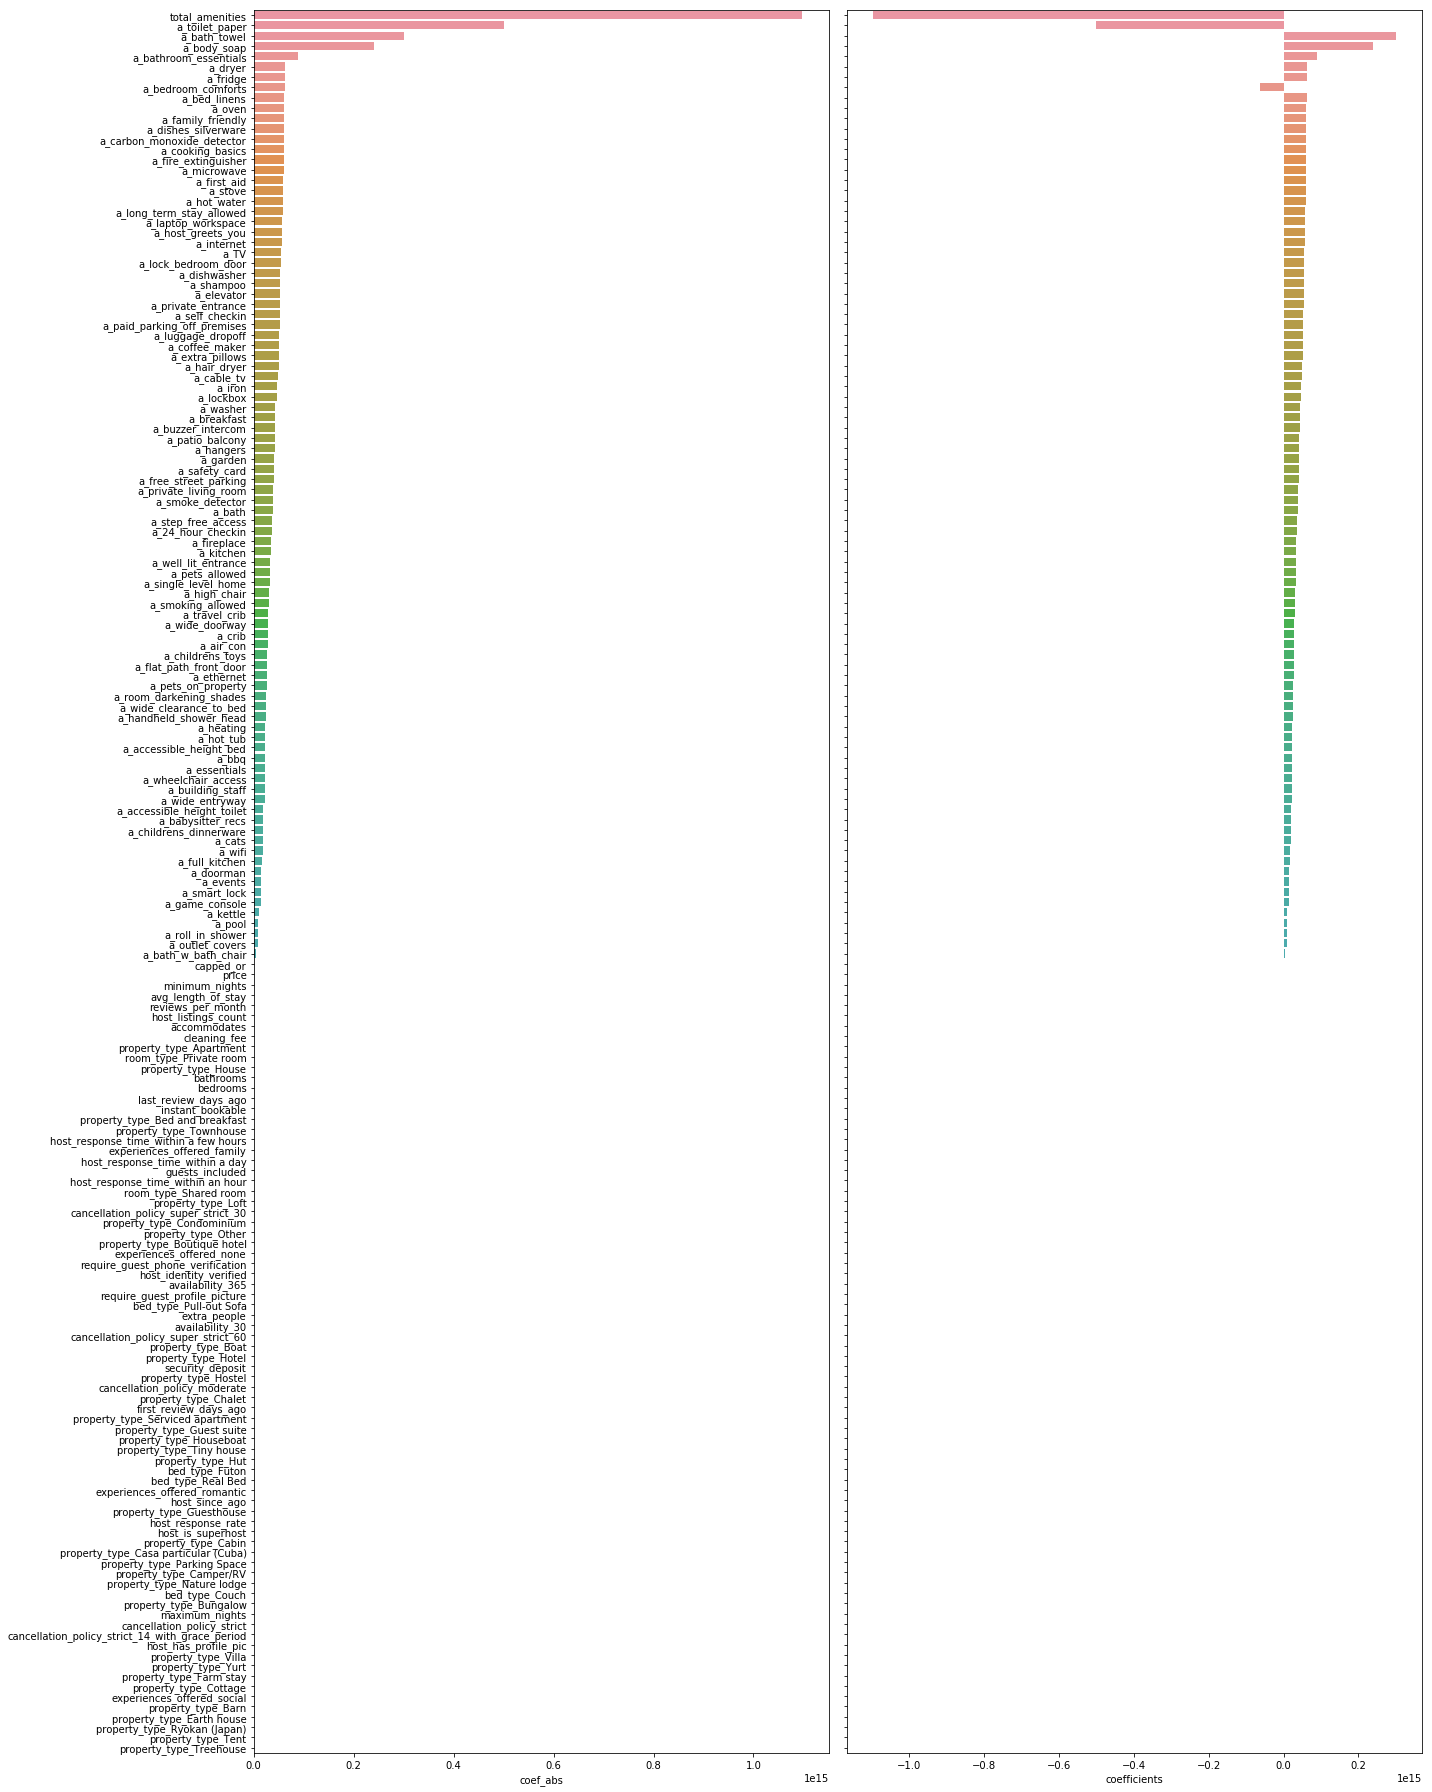

In [63]:
# 3c. ALL features + amenities 69.7% (BEST SO FAR - but too many amenities - this will lead to overfitting):

main_feats=['reviews_per_month', 'price','cleaning_fee','minimum_nights','avg_length_of_stay','capped_or',
           'host_is_superhost', 'security_deposit','host_response_rate','host_response_time','host_since_ago',
'host_listings_count','room_type','host_has_profile_pic','host_identity_verified','property_type','accommodates',
'bathrooms','bedrooms','guests_included','extra_people','maximum_nights','availability_30','availability_365',
'instant_bookable','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification',
'first_review_days_ago','last_review_days_ago','bed_type' ,'experiences_offered','a_wifi', 'a_TV', 'a_cable_tv', 'a_kitchen', 'a_paid_parking_off_premises', 'a_smoking_allowed', 'a_free_street_parking', 'a_buzzer_intercom', 'a_heating', 'a_family_friendly', 'a_washer', 'a_dryer', 'a_smoke_detector', 'a_carbon_monoxide_detector', 'a_fire_extinguisher', 'a_essentials', 'a_shampoo', 'a_lock_bedroom_door', 'a_hangers', 'a_hair_dryer', 'a_iron', 'a_laptop_workspace', 'a_outlet_covers', 'a_bath', 'a_childrens_toys', 'a_babysitter_recs', 'a_crib', 'a_travel_crib', 'a_room_darkening_shades', 'a_childrens_dinnerware', 'a_hot_water', 'a_bed_linens', 'a_extra_pillows', 'a_ethernet', 'a_coffee_maker', 'a_fridge', 'a_dishes_silverware', 'a_cooking_basics', 'a_oven', 'a_stove', 'a_patio_balcony', 'a_luggage_dropoff', 'a_long_term_stay_allowed', 'a_step_free_access', 'a_wide_doorway', 'a_accessible_height_bed', 'a_bath_w_bath_chair', 'a_accessible_height_toilet', 'a_host_greets_you', 'a_handheld_shower_head', 'a_wide_clearance_to_bed', 'a_roll_in_shower', 'a_high_chair', 'a_well_lit_entrance', 'a_flat_path_front_door', 'a_smart_lock', 'a_full_kitchen', 'a_kettle', 'a_wide_entryway', 'a_hot_tub', 'a_single_level_home', 'a_events', 'a_toilet_paper', 'a_bathroom_essentials', 'a_bedroom_comforts', 'a_wheelchair_access', 'a_pool', 'a_doorman', 'a_bath_towel', 'a_garden', 'a_first_aid', 'a_safety_card', 'a_microwave', 'a_internet', 'a_bbq', 'a_private_living_room', 'a_private_entrance', 'a_body_soap', 'a_breakfast', 'a_game_console', 'a_air_con', 'a_24_hour_checkin', 'a_self_checkin', 'a_elevator', 'a_fireplace', 'a_dishwasher', 
            'a_cats', 'a_pets_allowed', 'a_lockbox', 'a_building_staff', 'a_pets_on_property', 'total_amenities']
        

y = data_mf.income
X = pd.get_dummies(data_mf[main_feats],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

lr.fit(X_train,y_train)
print(lr.score(X_test, y_test))

df_coef = pd.DataFrame(lr.coef_, index=X.columns,
                       columns=['coefficients'])

df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef = df_coef.sort_values('coef_abs', ascending=False)
fix, ax = plt.subplots(ncols=2,figsize=(20,25),sharey=True)
sns.barplot(df_coef.coef_abs,df_coef.index,ax=ax[0])
sns.barplot(df_coef.coefficients,df_coef.index,ax=ax[1])
plt.tight_layout()
plt.show()

In [64]:
# 3d. ALL features + summary vaders 68.9%:

main_feats=['reviews_per_month', 'price','cleaning_fee','minimum_nights','avg_length_of_stay','capped_or',
           'host_is_superhost', 'security_deposit','host_response_rate','host_response_time','host_since_ago',
'host_listings_count','room_type','host_has_profile_pic','host_identity_verified','property_type','accommodates',
'bathrooms','bedrooms','guests_included','extra_people','maximum_nights','availability_30','availability_365',
'instant_bookable','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification',
'first_review_days_ago','last_review_days_ago','bed_type' ,'experiences_offered','vader_pos_desc','vader_neg_desc','vader_neu_desc','vader_compound_desc',
         'vader_pos_summary','vader_neg_summary','vader_neu_summary','vader_compound_summary']
        

y = data_mf.income
X = pd.get_dummies(data_mf[main_feats],drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

lr.fit(X_train,y_train)
lr.score(X_test, y_test)

0.6894315837028557

# Narrow Down Features (Those That Boost Accuracy Only)

Went through all features one-by-one, checking to see which add to accuracy, while controlling for total number of features.

- removed property_type because too many dummies
- removed d_national_gallery because was by FAR the largest coefficient, and didn't seem right.

Train Score:  0.6884050335453
Cross-Val Score:  0.686009097976023
Test Score:  0.6956545357280737


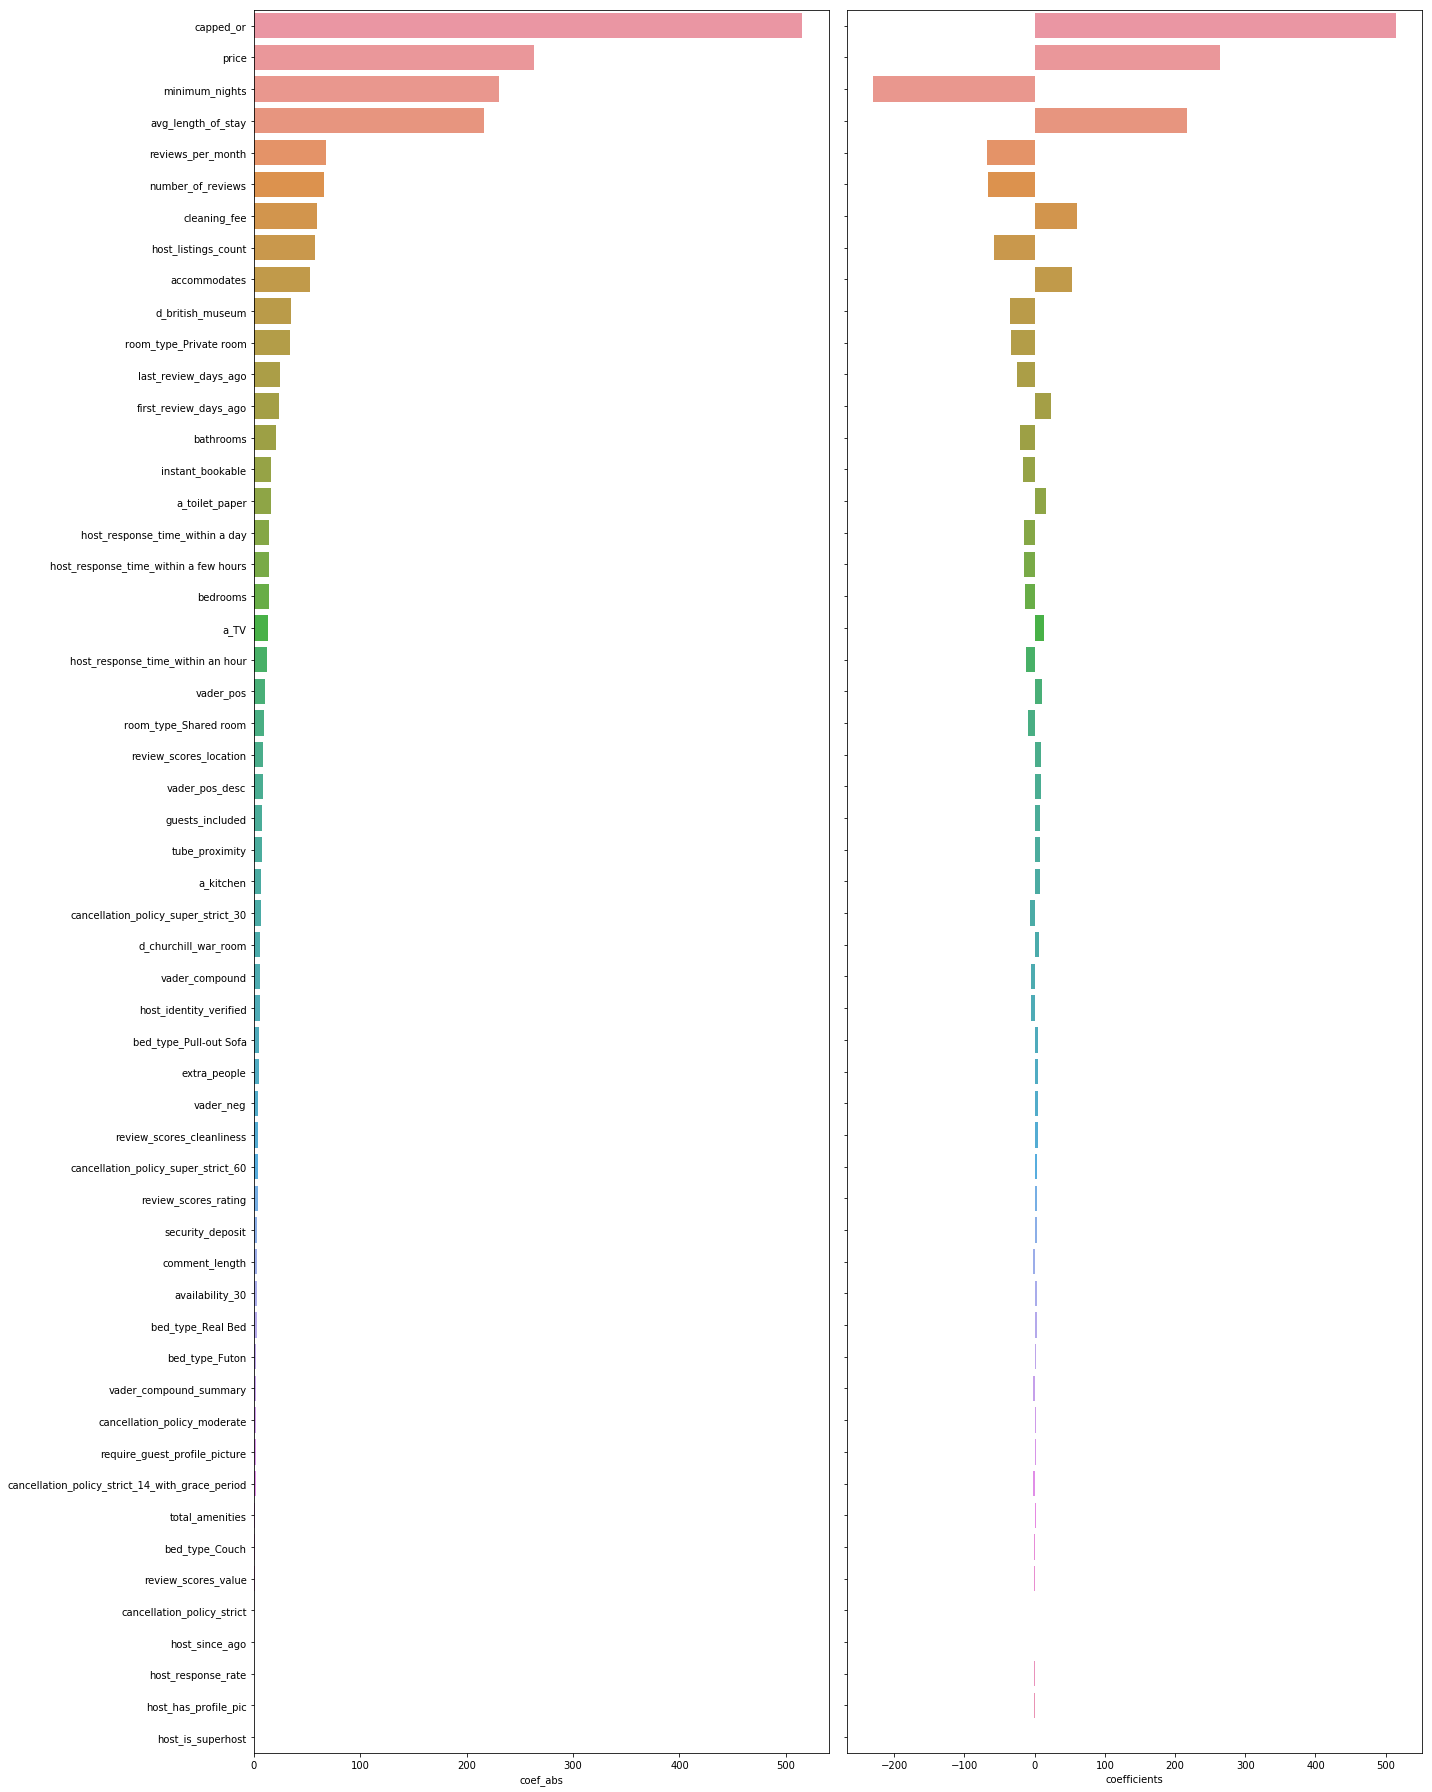

In [109]:
cols = data_mf[['reviews_per_month', 'price','cleaning_fee','minimum_nights','avg_length_of_stay','capped_or',
               'host_is_superhost','security_deposit','host_response_rate','host_response_time','host_since_ago',
               'host_listings_count','room_type','host_has_profile_pic','host_identity_verified',
               'accommodates','bathrooms','bedrooms','guests_included','extra_people','availability_30','instant_bookable',
               'cancellation_policy','require_guest_profile_picture','first_review_days_ago','last_review_days_ago','bed_type',
               'vader_pos_desc','vader_compound_summary','tube_proximity','d_british_museum','d_churchill_war_room',
               'review_scores_rating','review_scores_value','review_scores_location','review_scores_cleanliness','number_of_reviews',
               'vader_pos','vader_neg','comment_length','vader_compound','a_TV','a_kitchen','total_amenities','a_toilet_paper']]
    
y = data_mf.income
X = pd.get_dummies(cols,drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

fitter2(lr, X_train, y_train, X_test, y_test)

Plotting the predicted test values against the true test values, we can see the strength in the model lies in the 
lower income listings - likely to be because there are more of them, so there's more data to train on.
The weakness is higher income listings: the model often predicts income too high. This may be because there aren't many data points to train on, and/or that high income listings are very varied.


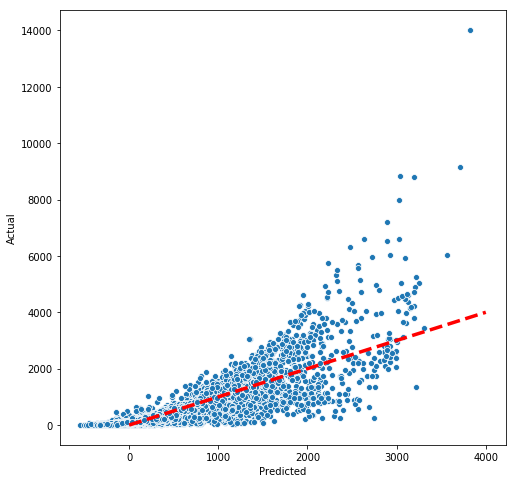

In [110]:
preds = lr.predict(X_test)
fig = plt.figure(figsize = (8,8))
sns.scatterplot(preds, y_test)
boundaries = [0, 4000]
plt.plot(boundaries, boundaries, '--r',lw=3.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [118]:
p = pd.DataFrame(preds)
p[p[0]<0]

,0
4,-26.785849
8,-243.399768
42,-31.845377
52,-668.433681
55,-369.257859
56,-30.790334
59,-6.890550
86,-262.901293
91,-333.566845
97,-280.589326


Train Score:  0.3491867044264485
Cross-Val Score:  0.3459537533436975
Test Score:  0.3505624412393705


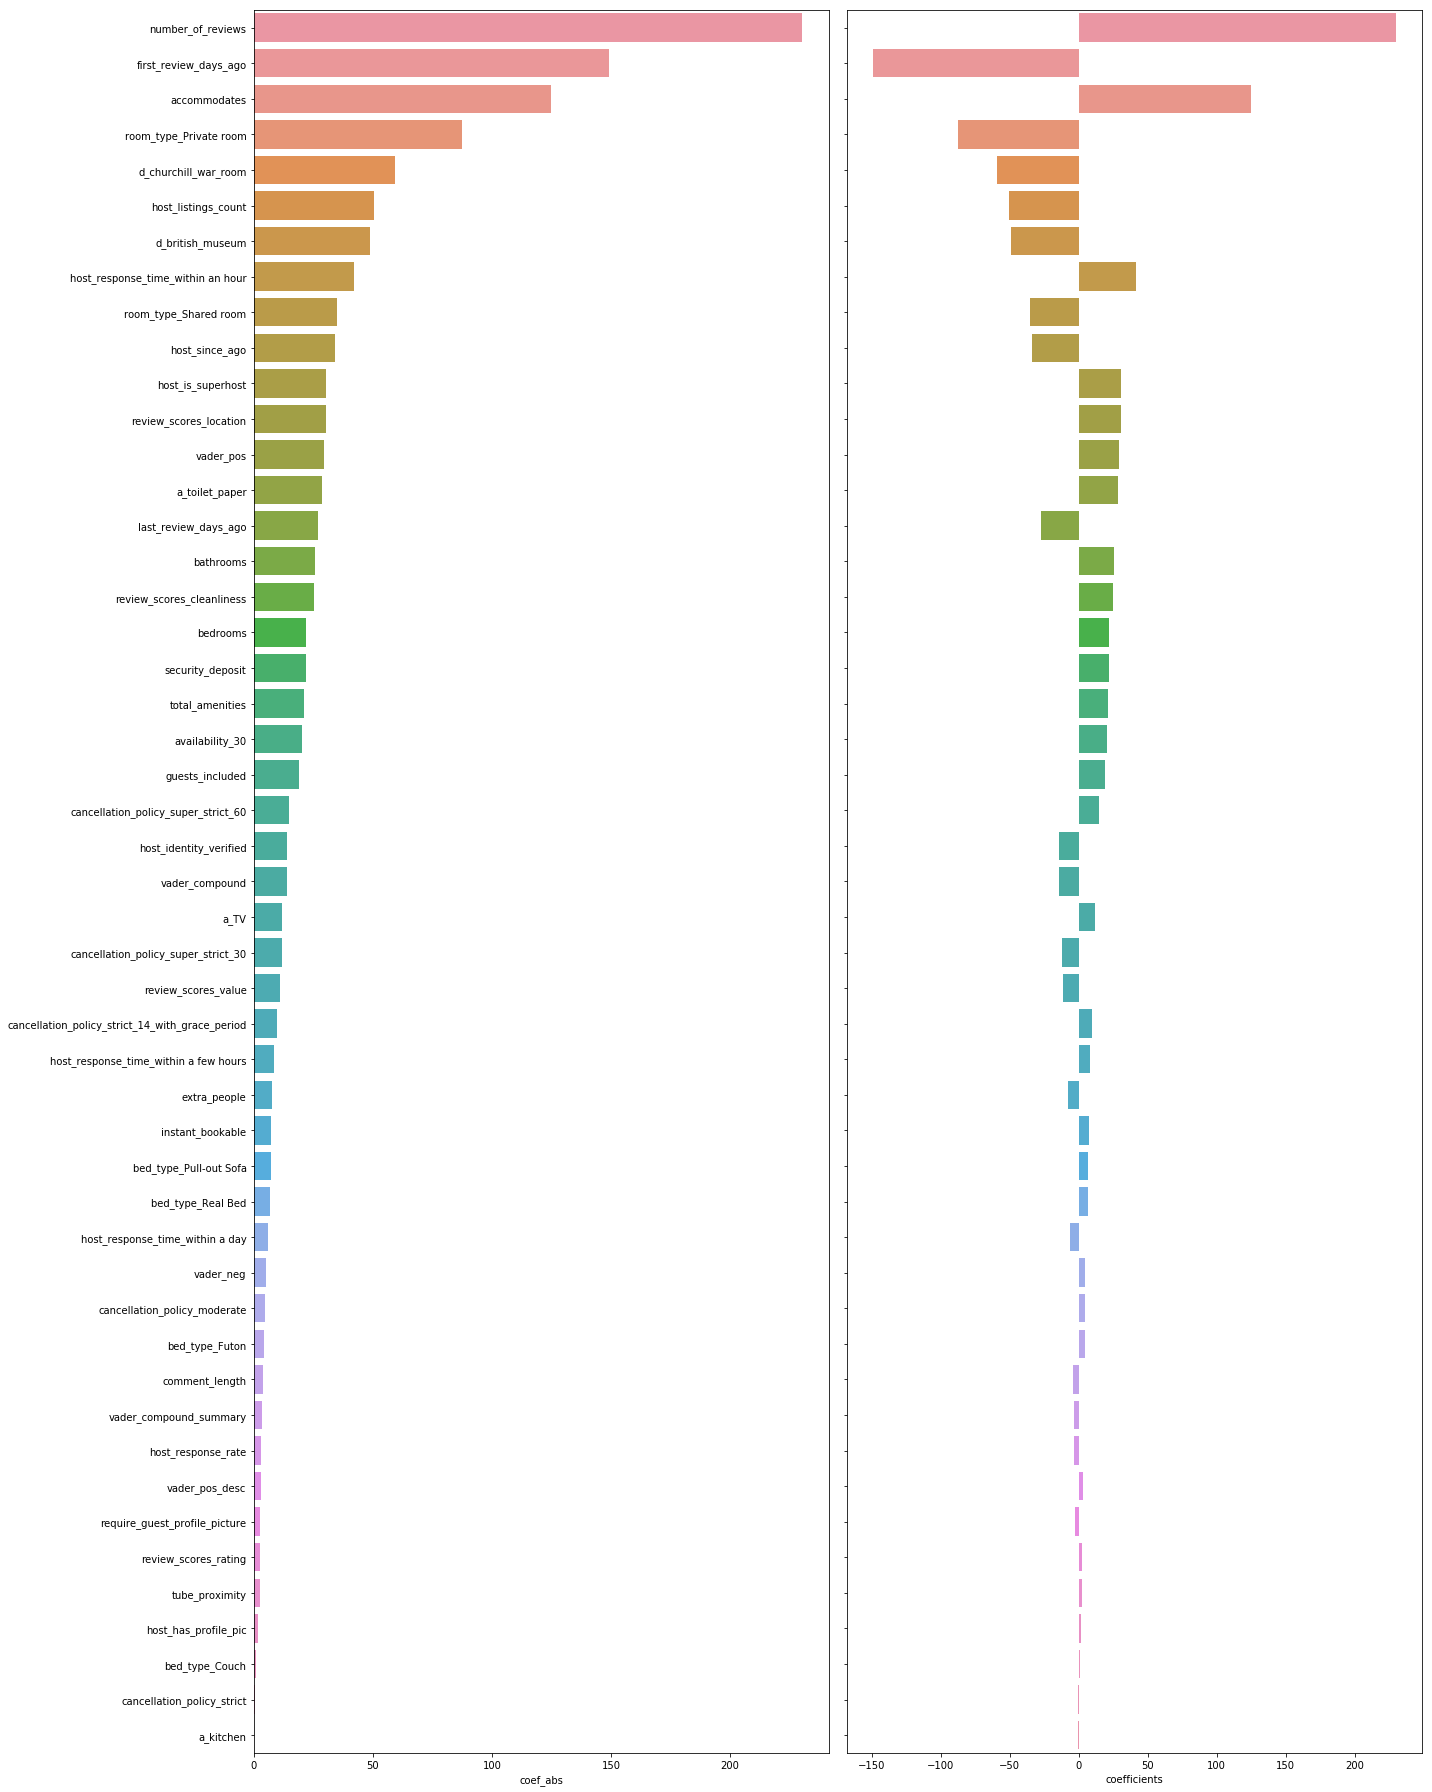

In [111]:
# Without formula-based predictors

cols = data_mf[[
               'host_is_superhost','security_deposit','host_response_rate','host_response_time','host_since_ago',
               'host_listings_count','room_type','host_has_profile_pic','host_identity_verified',
               'accommodates','bathrooms','bedrooms','guests_included','extra_people','availability_30','instant_bookable',
               'cancellation_policy','require_guest_profile_picture','first_review_days_ago','last_review_days_ago','bed_type',
               'vader_pos_desc','vader_compound_summary','tube_proximity','d_british_museum','d_churchill_war_room',
               'review_scores_rating','review_scores_value','review_scores_location','review_scores_cleanliness','number_of_reviews',
               'vader_pos','vader_neg','comment_length','vader_compound','a_TV','a_kitchen','total_amenities','a_toilet_paper']]
    
y = data_mf.income
X = pd.get_dummies(cols,drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

fitter2(lr, X_train, y_train, X_test, y_test)

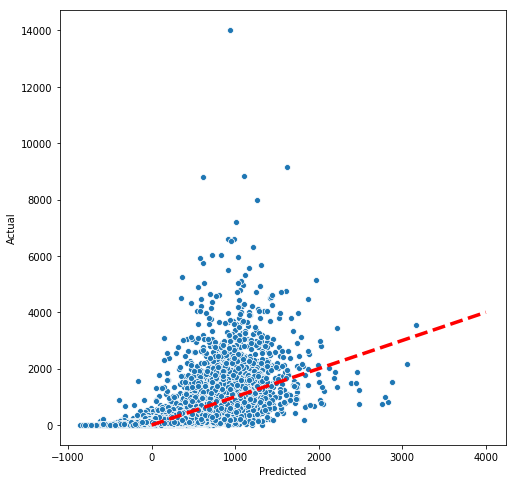

In [112]:
preds = lr.predict(X_test)
fig = plt.figure(figsize = (8,8))
sns.scatterplot(preds, y_test)
boundaries = [0, 4000]
plt.plot(boundaries, boundaries, '--r',lw=3.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Find The Best Model

In [120]:
# Search for best model based on non-formula predictors

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNet, ElasticNetCV

best_without_formula = data_mf[['host_is_superhost','security_deposit','host_response_rate','host_response_time','host_since_ago',
               'host_listings_count','room_type','host_has_profile_pic','host_identity_verified',
               'accommodates','bathrooms','bedrooms','guests_included','extra_people','availability_30','instant_bookable',
               'cancellation_policy','require_guest_profile_picture','first_review_days_ago','last_review_days_ago','bed_type',
               'vader_pos_desc','vader_compound_summary','tube_proximity','d_british_museum','d_churchill_war_room',
               'review_scores_rating','review_scores_value','review_scores_location','review_scores_cleanliness','number_of_reviews',
               'vader_pos','vader_neg','comment_length','vader_compound','a_TV','a_kitchen','total_amenities','a_toilet_paper']]
    
y = data_mf.income
X = pd.get_dummies(best_without_formula,drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [83]:
l1_ratios = np.linspace(0.01, 1.0, 25)
models = [KNeighborsRegressor(n_neighbors=5),
          LinearRegression(),
          Lasso(alpha=0.35),
          Ridge(alpha=21),
          ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10),
          DecisionTreeRegressor(),
          SVR(gamma='scale'),
          RandomForestRegressor(n_estimators=100)]

res = []

for model in models:
    print(model)
    print()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = model.score(X_test, y_test)
    print(score)
    print() 
    res.append([model, score])
    print() 
    print('-'*60)
    print()

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

0.3169926454207014


------------------------------------------------------------

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

0.3505624412393705


------------------------------------------------------------

Lasso(alpha=0.35, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

0.350382926840866


------------------------------------------------------------

Ridge(alpha=21, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

0.35056400155635425


------------------------------------------------------------

ElasticNetCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
       l1_rat

**RandomForestRegressor output the best accuracy score, let's investigate further**

Train Score:  0.9442931784024206
Cross-Val Score:  0.5954439635533791
Test Score:  0.6354860622290557


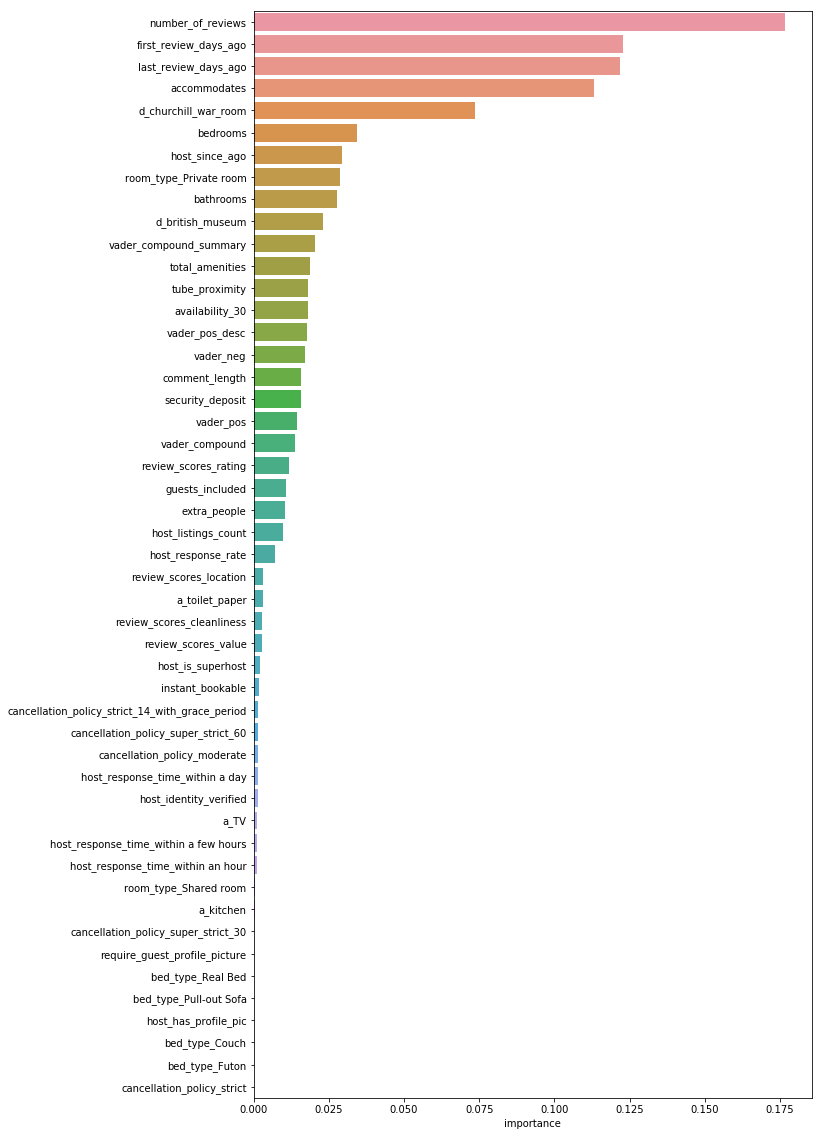

In [100]:
# Plot RFR to see the feature importances:

model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

model.fit(X_train,y_train)
print("Train Score: ",model.score(X_train, y_train))
print("Cross-Val Score: ",cross_val_score(model, X_train, y_train, cv=5).mean())
print("Test Score: ",model.score(X_test, y_test))

feature_importances = pd.DataFrame(model.feature_importances_,
                                   index=X.columns,
                                   columns=['importance'])
feature_importances['absolute_values'] = feature_importances.importance.abs()
feature_importances = feature_importances.sort_values(by='importance', ascending=False)


plt.figure(figsize=(10,20))
sns.barplot(feature_importances.importance,feature_importances.index)
plt.show()

In [121]:
#GridSearchCV on RF:

model = RandomForestRegressor(criterion='mse',random_state=1)


params = {'max_features' : [30,35,45], # number of features to consider when looking for the best split
          'min_samples_leaf' : [1,5,10],# how many samples need to be included at a leaf, at a minimum?
          'min_samples_split' : [2,3]#how many samples need to be included at a node, at a minium?
          }# number of trees in the forest
         
gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=3,
                  return_train_score=True)

gs.fit(X_train,y_train)
print(gs.score(X_test, y_test))

0.610450772232648


In [122]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=35, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=None, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [103]:
data_mf.first_review_days_ago.describe()

count    44105.000000
mean       672.210475
std        532.273671
min         83.000000
25%        255.000000
50%        518.000000
75%        962.000000
max       3446.000000
Name: first_review_days_ago, dtype: float64

Train Score:  0.3491540398011931
Cross-Val Score:  0.34602599910755216
Test Score:  0.350382926840866


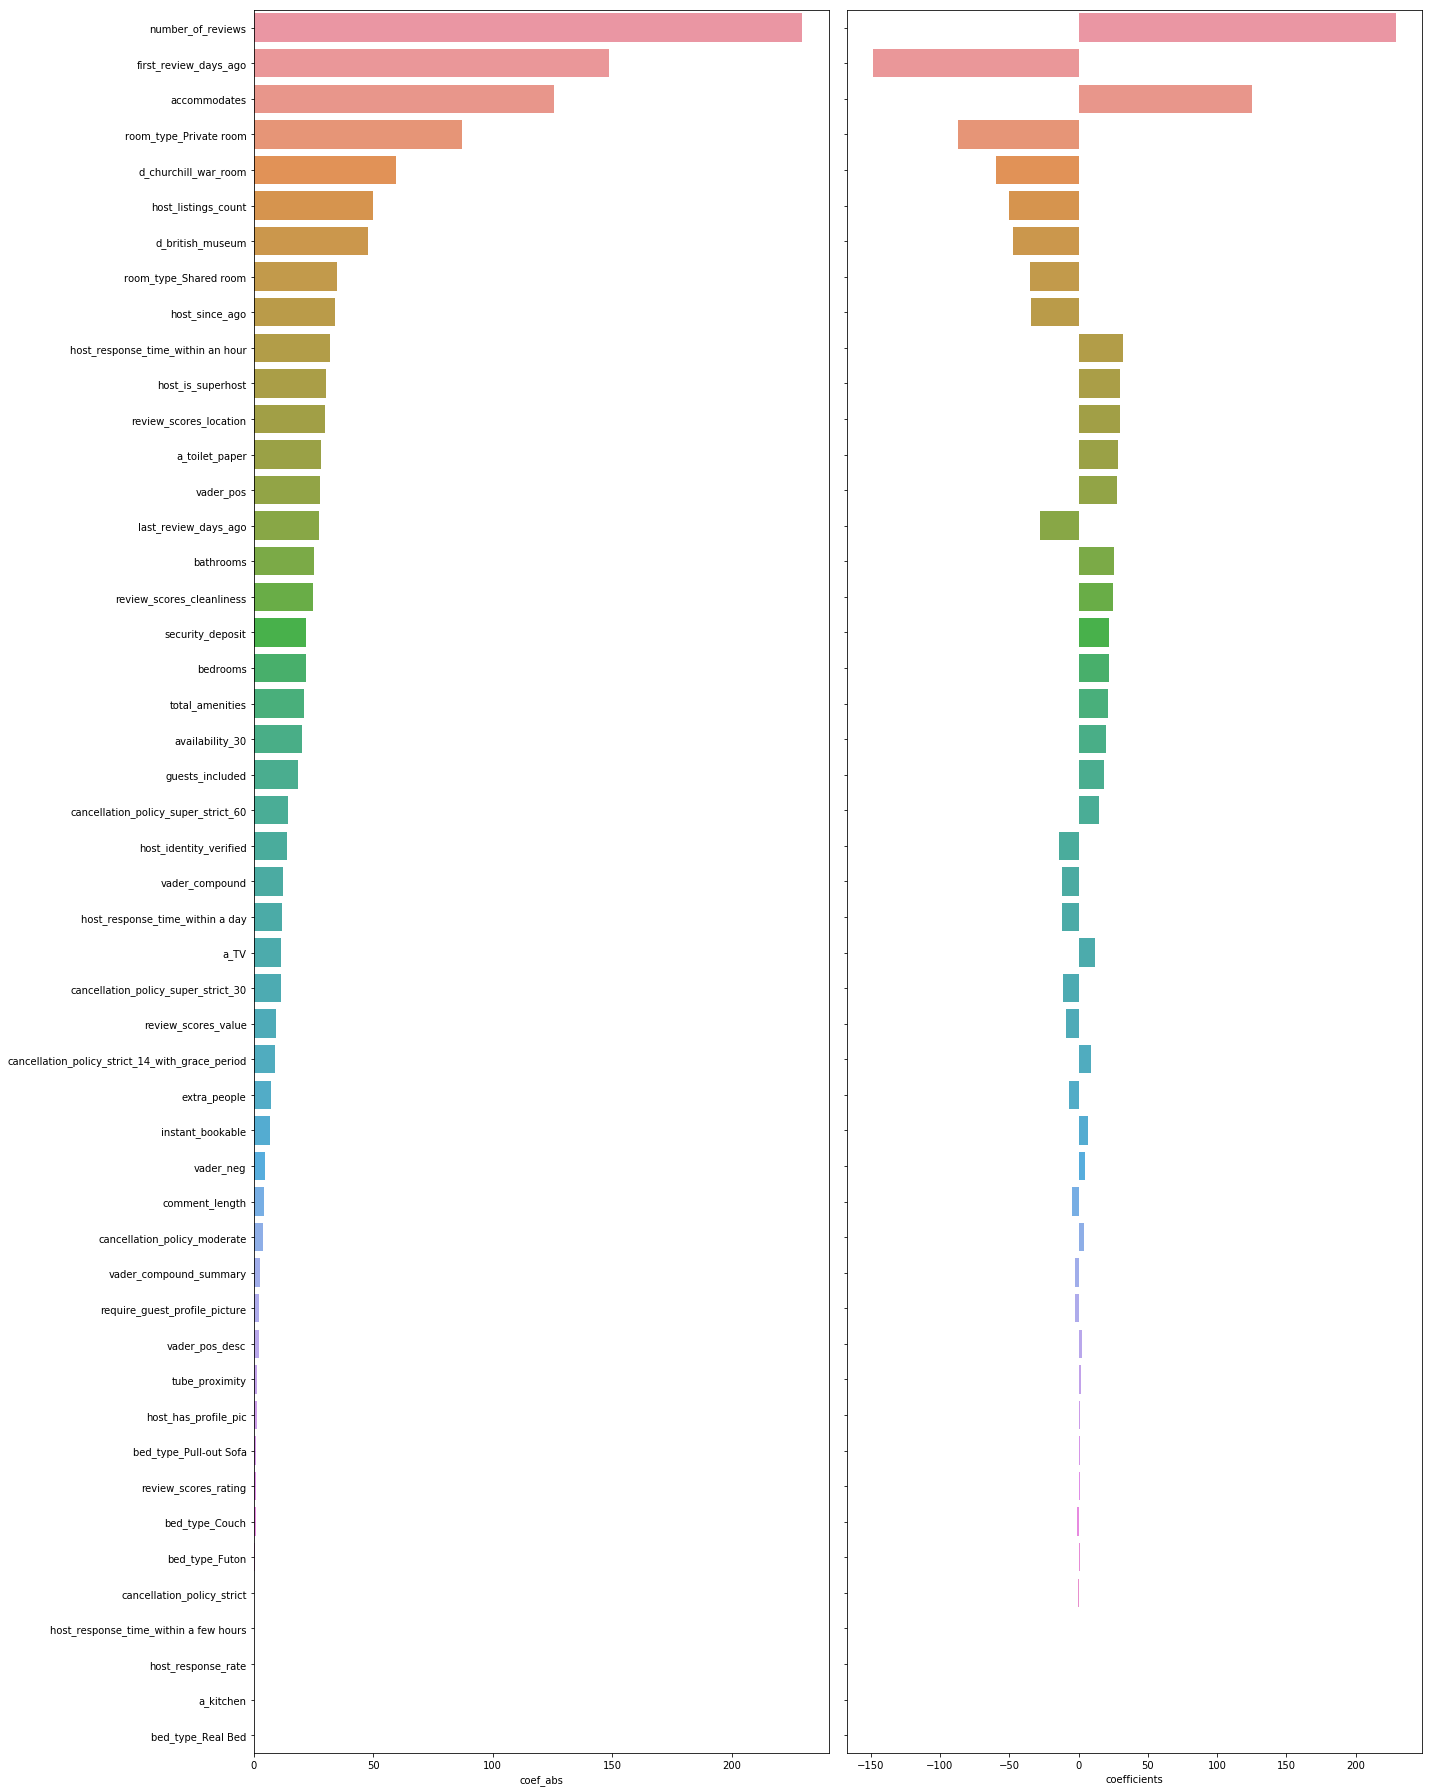

In [125]:
# Lasso coefficients

model = Lasso(alpha=0.35, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

fitter2(model, X_train, y_train, X_test, y_test)

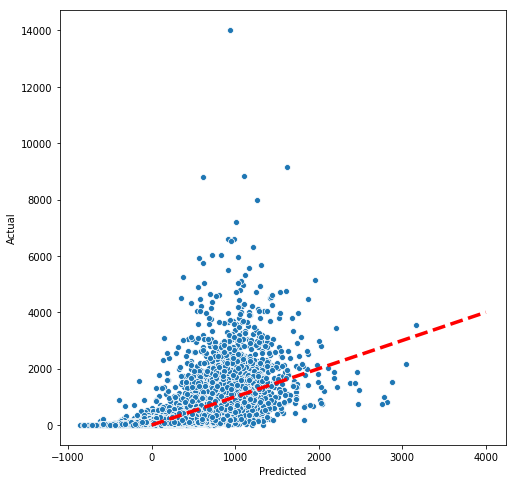

In [126]:
preds = model.predict(X_test)
fig = plt.figure(figsize = (8,8))
sns.scatterplot(preds, y_test)
boundaries = [0, 4000]
plt.plot(boundaries, boundaries, '--r',lw=3.5)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Conclusion Thus Far

That is part 1 concluded. So far, I've pulled the data, cleaned, feature engineered and prepared it for exploration. I then explored the data through trying different variables as targets. Overall, it's clear the data is widely diverse, and many predictors have highly skewed distributions. This made modelling with regression difficult.

Not only that, but modelling proved difficult because of the sheer numbr of predictors available. I had no choice but to narrow down what was used. This was done by adding variables one-by-one to a Linear Regression - 45 predictors remained. A handful of these variables were used in the formulation of the target variable though. Throughout, I modelled on both the full 45, and then removing the few variables.

My RandomForestRegressor model proved the most accurate with scores of 99% and 75.9% accuracy. The first model shouldn't be counted though as it includes formula-based predictors.

In terms of feature importance, looking at the chart from the 75.9% accurate RF is interesting:
- Distance to certain tourist locations like Churchill War Rooms and British Museum are key
- How many people your listing can accommodate is
- When you first and last reviews is.
- How long you've been a host
- How many beds and baths there are.

It's possibly even more interesting to look at the coefficients from the LinearRegression. As for every unit increase in a certain variable, we can see income per month increase or decrease. For example:

- Every £1 extra price per night = £160 more income pm. Charge more money!
- Every extra person a listing can accomodate = +£30 more income pm. Add an extra sofa bed!
- Every extra listing a host has = -£50 income pm (on an individual listing). Spreading themselves too thin?

**Side note**:I had tried a GridSearchCV on my RandomForestRegressor, unfortunately the computing power required was too much for my laptop!

# What Next?

Now that I've thoroughly investigated income as a continuous problem, I will now view it as a classification problem. This can be found on my Classification Notebook.

Below, I've also dug a bit deeper into segmenting by borough, and discussed potential further work there.

# Going Further: Segmenting By Boroughs

London is such a varied city that looking at it as a whole could make it harder to train our data - boroughs behave so differently. E.g. Hillingdon has the highest occupancy rate but a very low average price per night. City of London has a low number of listings but one of the highest income totals.

It might be interesting to break down models by borough.

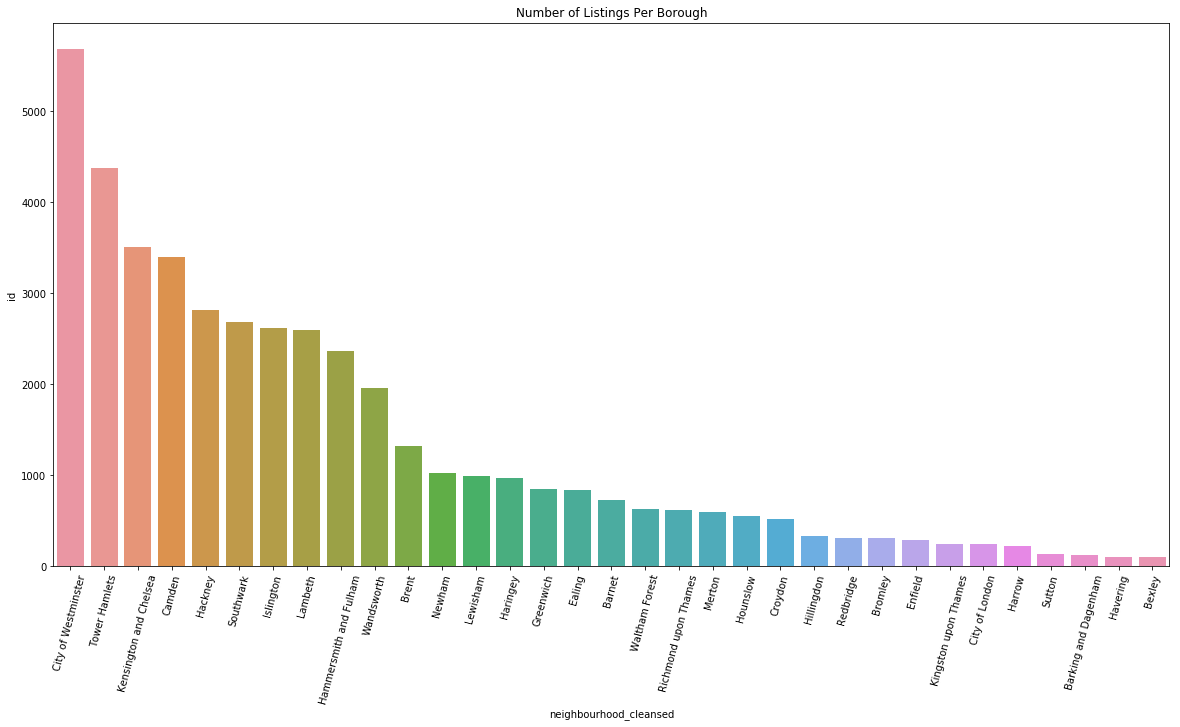

In [93]:
# A quick look at number of listings by borough:
nei_listings = data_mf.groupby('neighbourhood_cleansed')[['id']].count().sort_values(by='id',ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x=nei_listings.index,y=nei_listings.id)
plt.xticks(rotation=75)
plt.title("Number of Listings Per Borough")
plt.show()

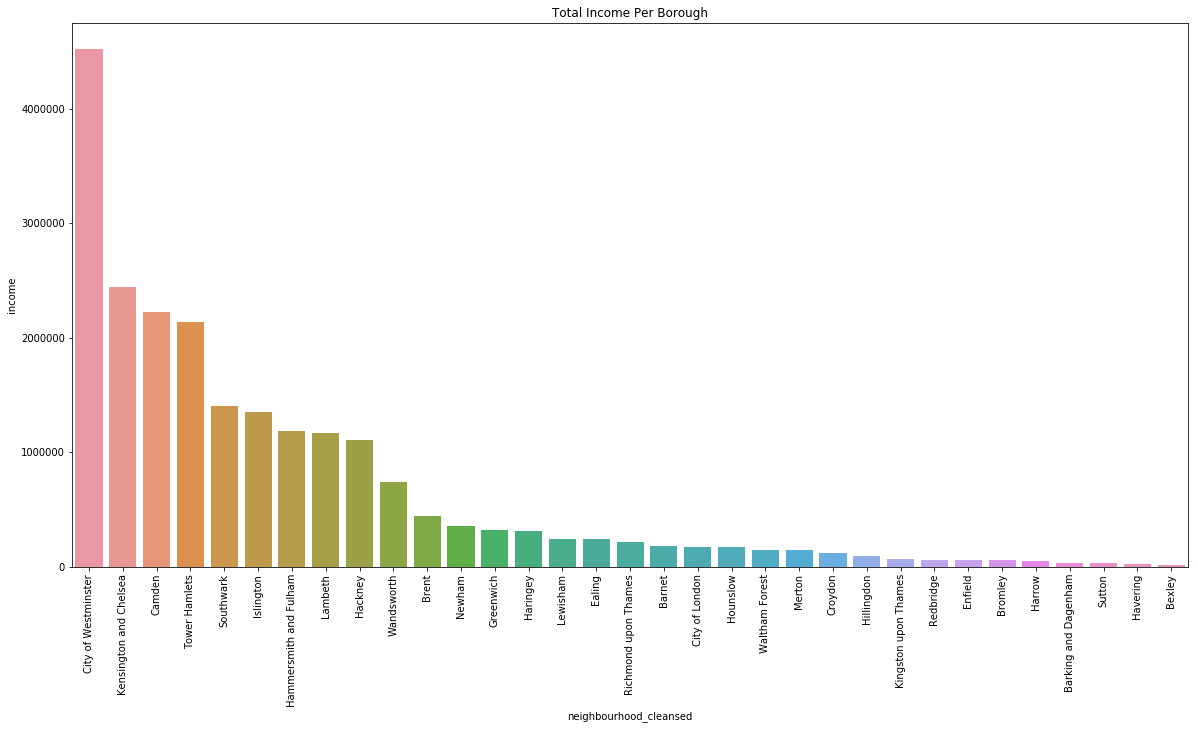

In [209]:
# Total Income Per Borough:
nei_income = data_mf.groupby('neighbourhood_cleansed')[['income']].sum().sort_values(by='income',ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x=nei_income.index,y=nei_income.income)
plt.xticks(rotation=90)
plt.title("Total Income Per Borough")
plt.show()

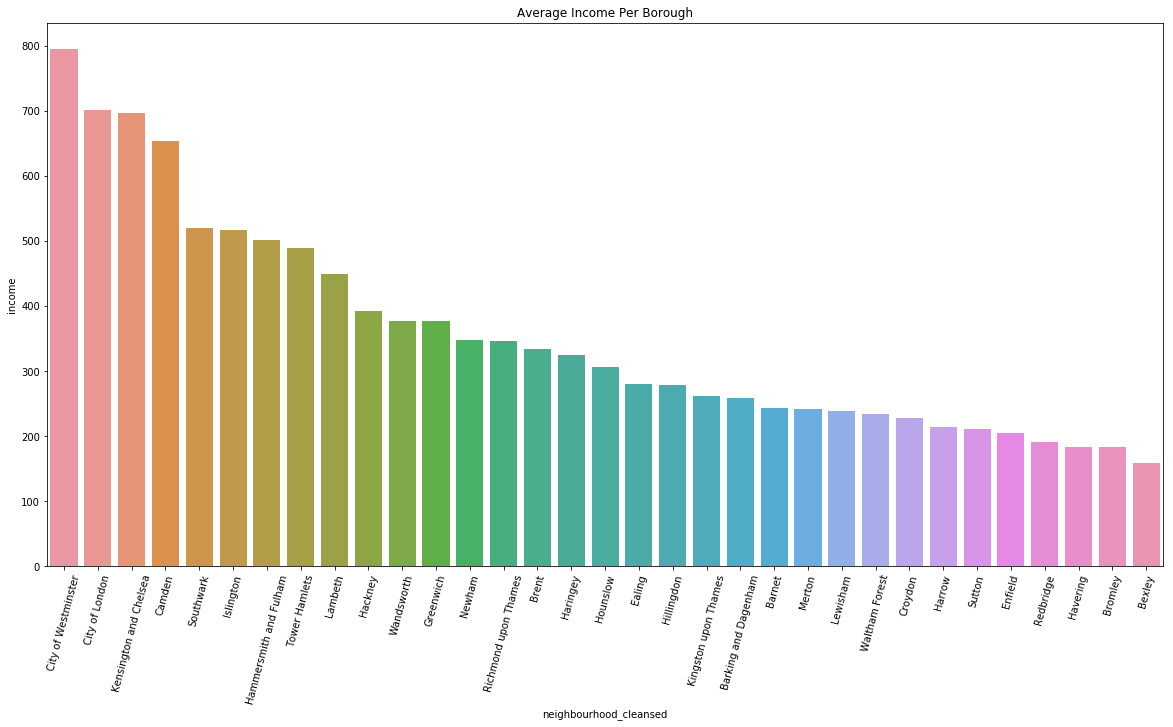

In [210]:
# Average Income Per Borough:

nei_income_avg = data_mf.groupby('neighbourhood_cleansed')[['income']].mean().sort_values(by='income',ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x=nei_income_avg.index,y=nei_income_avg.income)
plt.xticks(rotation=75)
plt.title("Average Income Per Borough")
plt.show()

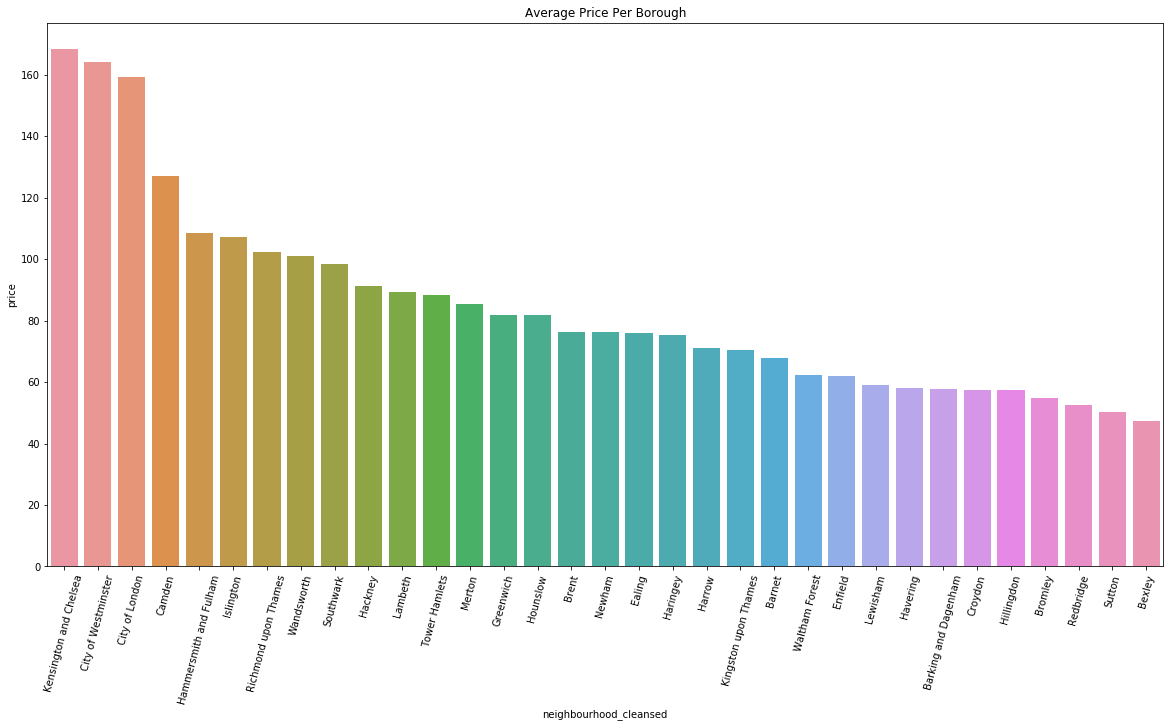

In [90]:
# Average Price Per Night Per Borough:

nei_price_avg = data_mf.groupby('neighbourhood_cleansed')[['price']].mean().sort_values(by='price',ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x=nei_price_avg.index,y=nei_price_avg.price)
plt.xticks(rotation=75)
plt.title("Average Price Per Borough")
plt.show()

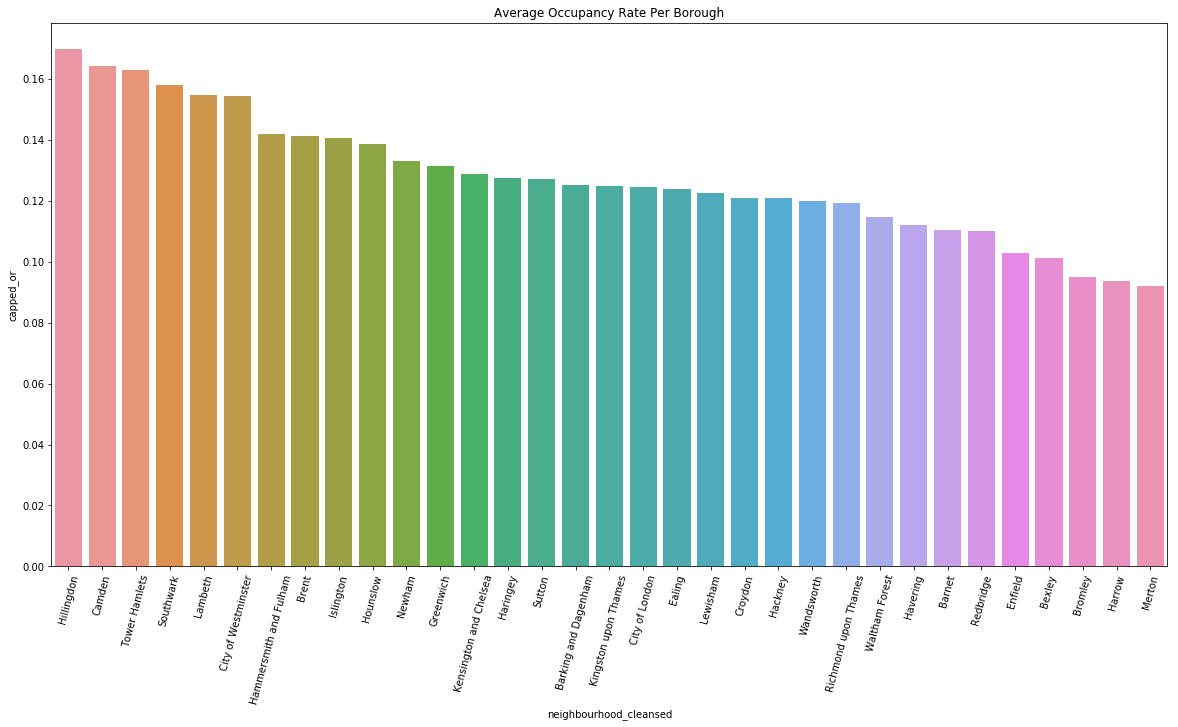

In [91]:
# Average Occupacy Rate Per Borough:
nei_or_avg = data_mf.groupby('neighbourhood_cleansed')[['capped_or']].mean().sort_values(by='capped_or',ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x=nei_or_avg.index,y=nei_or_avg.capped_or)
plt.xticks(rotation=75)
plt.title("Average Occupancy Rate Per Borough")
plt.show()

# Hillingdon is by Heathrow!!
# Top 3 earners don't top occ rates. Just priced significantly higher than others.

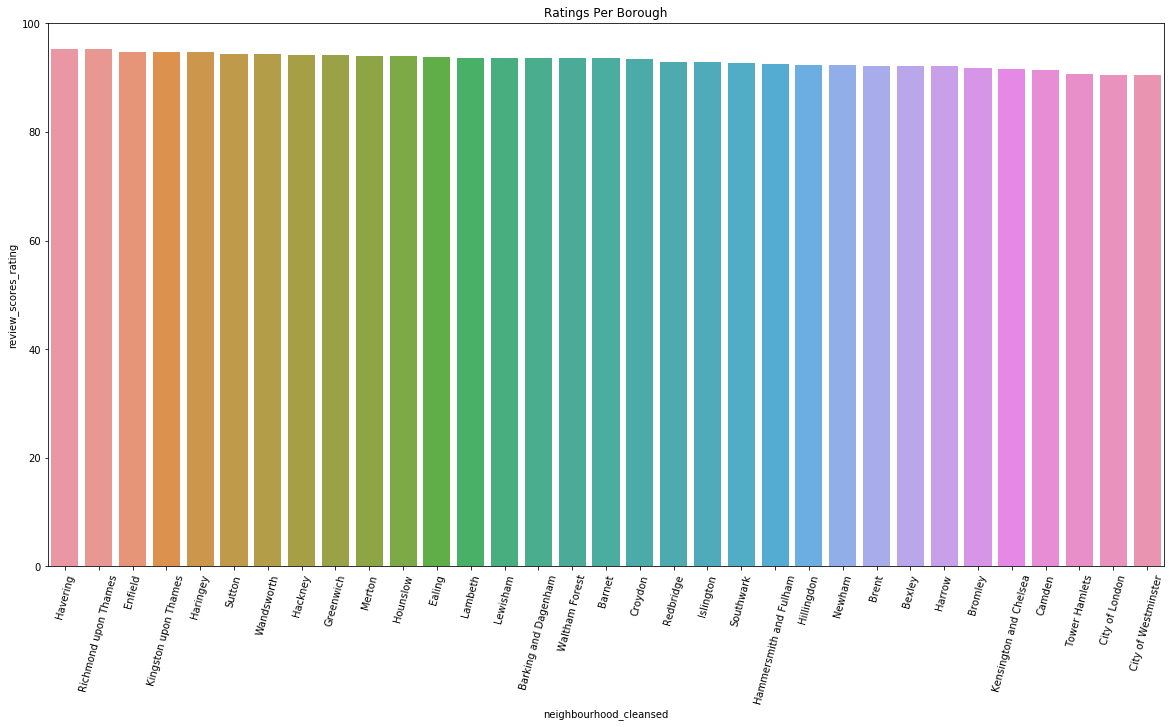

In [94]:
# Ratings by Borough:
nei_ratings = data_mf.groupby('neighbourhood_cleansed')[['review_scores_rating']].mean().sort_values(by='review_scores_rating',ascending=False)
plt.figure(figsize=(20,10))
sns.barplot(x=nei_ratings.index,y=nei_ratings.review_scores_rating)
plt.xticks(rotation=75)
plt.title("Ratings Per Borough")
plt.show()

#Top earners have worst ratings!

In [65]:
# Create a function which models on a specific borough (with Linear Regression), given a dataframe and predictors.

def by_borough(borough, data_mf,cols):
    

    x = data_mf.loc[data_mf['neighbourhood_cleansed'] == borough]

    features = x[cols]

    y = x.capped_or_income
    X = pd.get_dummies(features,drop_first=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

    lr = LinearRegression()
    lr.fit(X_train,y_train)
    return lr.score(X_test, y_test)

In [81]:
# Example look at how varied scores are for boroughs on the same predictor set. 
# I've only used boroughs with > 700 listings as the data sets are already small as is.

cols = ['host_is_superhost','price','cleaning_fee','minimum_nights','capped_or',
            'tube_proximity','host_response_rate','host_since_ago',
'host_listings_count','room_type','host_identity_verified','longitude','accommodates','bathrooms','bedrooms','beds',
'extra_people','availability_30','availability_60',
'availability_90','availability_365','number_of_reviews','review_scores_accuracy',
'instant_bookable','require_guest_profile_picture','require_guest_phone_verification',
'first_review_days_ago','cleaning_fee']

boroughs = ['City of Westminster','Tower Hamlets','Kensington and Chelsea','Camden','Hackney','Southwark','Islington',
'Lambeth','Hammersmith and Fulham','Wandsworth','Brent','Newham','Lewisham', 'Haringey','Waltham Forest']

for borough in boroughs:
    b = by_borough(borough, data_mf, cols)
    print (borough, b)

City of Westminster 0.6473865825324998
Tower Hamlets 0.712891056124761
Kensington and Chelsea 0.7069313265489618
Camden 0.6401035297209995
Hackney 0.6841314218093024
Southwark 0.6573157078613068
Islington 0.36580703119733693
Lambeth 0.683131040799971
Hammersmith and Fulham 0.6356035833553655
Wandsworth 0.6480461629191999
Brent 0.7167870422129627
Newham 0.7010074381959805
Lewisham 0.5958807779322679
Haringey 0.6220656139945051
Waltham Forest 0.7335412437534974


There definitely seems to be potential and reason to create unique models per borough as they behave quite differently in terms of price, occ rate, income, ratings, types of customers they attract (e.g. family / tourist / business)

# Improving Feature Selection

After researching further on feature selection, I found the sklearn package feature_selection - it helps you discover the best set of predictors. Looking closely at RFE (Recursive Feature Elimiation), I input a range of 154 features, and had it iterate over all possible combinations (which took a long time to compute!). It output 152 as being the combination with highest accuracy. This gives 39% accuracy with a simple Linear Regression. Though, better than the 35% achieved through my manual selection, I won't move forward with it as it almost certainly overfits the model.

In [212]:
# List of all non-formula based features to iterate over:

test=['host_is_superhost', 'security_deposit','host_response_rate','host_response_time','host_since_ago',
'host_listings_count','room_type','host_has_profile_pic','host_identity_verified','property_type','accommodates',
'bathrooms','bedrooms','guests_included','extra_people','maximum_nights','availability_30','availability_365',
'instant_bookable','cancellation_policy','require_guest_profile_picture','require_guest_phone_verification',
'first_review_days_ago','last_review_days_ago','bed_type' ,'experiences_offered',
           'review_scores_rating','review_scores_accuracy','review_scores_checkin','review_scores_communication',
          'review_scores_value','review_scores_location','review_scores_cleanliness','number_of_reviews',
          'vader_pos','vader_neg','vader_neu','vader_compound','comment_length',
           'neighbourhood_cleansed','tube_proximity',
        'd_british_museum', 'd_tower_london', 'd_covent_garden', 'd_nat_hist_museum', 'd_nat_gallery', 'd_st_pauls', 'd_borough_market', 'd_va_museum',
        'd_tower_bridge', 'd_westminster_abbey', 'd_churchill_war_room','latitude','longitude',
           'a_wifi', 'a_TV', 'a_cable_tv', 'a_kitchen', 'a_paid_parking_off_premises', 'a_smoking_allowed', 'a_free_street_parking', 'a_buzzer_intercom', 'a_heating', 'a_family_friendly', 'a_washer', 'a_dryer', 'a_smoke_detector', 'a_carbon_monoxide_detector', 'a_fire_extinguisher', 'a_essentials', 'a_shampoo', 'a_lock_bedroom_door', 'a_hangers', 'a_hair_dryer', 'a_iron', 'a_laptop_workspace', 'a_outlet_covers', 'a_bath', 'a_childrens_toys', 'a_babysitter_recs', 'a_crib', 'a_travel_crib', 'a_room_darkening_shades', 'a_childrens_dinnerware', 'a_hot_water', 'a_bed_linens', 'a_extra_pillows', 'a_ethernet', 'a_coffee_maker', 'a_fridge', 'a_dishes_silverware', 'a_cooking_basics', 'a_oven', 'a_stove', 'a_patio_balcony', 'a_luggage_dropoff', 'a_long_term_stay_allowed', 'a_step_free_access', 'a_wide_doorway', 'a_accessible_height_bed', 'a_bath_w_bath_chair', 'a_accessible_height_toilet', 'a_host_greets_you', 'a_handheld_shower_head', 'a_wide_clearance_to_bed', 'a_roll_in_shower', 'a_high_chair', 'a_well_lit_entrance', 'a_flat_path_front_door', 'a_smart_lock', 'a_full_kitchen', 'a_kettle', 'a_wide_entryway', 'a_hot_tub', 'a_single_level_home', 'a_events', 'a_toilet_paper', 'a_bathroom_essentials', 'a_bedroom_comforts', 'a_wheelchair_access', 'a_pool', 'a_doorman', 'a_bath_towel', 'a_garden', 'a_first_aid', 'a_safety_card', 'a_microwave', 'a_internet', 'a_bbq', 'a_private_living_room', 'a_private_entrance', 'a_body_soap', 'a_breakfast', 'a_game_console', 'a_air_con', 'a_24_hour_checkin', 'a_self_checkin', 'a_elevator', 'a_fireplace', 'a_dishwasher', 'a_cats', 'a_pets_allowed', 'a_lockbox', 'a_building_staff', 'a_pets_on_property', 'total_amenities',
           'vader_pos_desc','vader_neg_desc','vader_neu_desc','vader_compound_desc',
         'vader_pos_summary','vader_neg_summary','vader_neu_summary','vader_compound_summary']
len(test)

154

In [ ]:
# RFE (Recursive Feature Elimination) to find the best x estimators

y = data_mf.income
X = pd.get_dummies(data_mf[test],drop_first=True)

from sklearn.feature_selection import RFE
#no of features
nof_list=np.arange(1,154)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True,test_size = 0.3, random_state = 0)
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

# 39% Score is better than the 35% from the Lasso with predictors I manually chose.

In [215]:
# List of 30 Top Features To Use:

cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 30)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['require_guest_phone_verification', 'vader_neu', 'vader_compound',
       'd_british_museum', 'd_covent_garden', 'd_westminster_abbey',
       'd_churchill_war_room', 'a_hangers', 'a_full_kitchen', 'a_bath_towel',
       'a_air_con', 'a_self_checkin', 'vader_neg_desc', 'vader_neg_summary',
       'host_response_time_within an hour', 'room_type_Shared room',
       'property_type_Boat', 'property_type_Cabin', 'property_type_Chalet',
       'property_type_Farm stay', 'property_type_Hostel',
       'property_type_Nature lodge', 'property_type_Tent',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'bed_type_Real Bed',
       'neighbourhood_cleansed_Brent', 'neighbourhood_cleansed_Ealing',
       'neighbourhood_cleansed_Havering', 'neighbourhood_cleansed_Wandsworth'],
      dtype='object')


In [100]:
# Save the features in a list:

selected_features_rfe = ['require_guest_phone_verification', 'vader_neu', 'vader_compound',
       'd_british_museum', 'd_covent_garden', 'd_westminster_abbey',
       'd_churchill_war_room', 'a_hangers', 'a_full_kitchen', 'a_bath_towel',
       'a_air_con', 'a_self_checkin', 'vader_neg_desc', 'vader_neg_summary',
       'host_response_time_within an hour', 'room_type_Shared room',
       'property_type_Boat', 'property_type_Cabin', 'property_type_Chalet',
       'property_type_Farm stay', 'property_type_Hostel',
       'property_type_Nature lodge', 'property_type_Tent',
       'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'bed_type_Real Bed',
       'neighbourhood_cleansed_Brent', 'neighbourhood_cleansed_Ealing',
       'neighbourhood_cleansed_Havering', 'neighbourhood_cleansed_Wandsworth']

In [95]:
dummies = pd.get_dummies(data_mf)
dummies.head(2)

,id,host_id,host_response_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,...,"latlongzip_(51.668690000000005, -0.17708)","latlongzip_(51.668929999999996, -0.016059999999999998)","latlongzip_(51.66969, -0.0334)","latlongzip_(51.67025, -0.02333)","latlongzip_(51.67071, -0.03285)","latlongzip_(51.67083, -0.015430000000000001)","latlongzip_(51.67090515246478, -0.04153304269768998)","latlongzip_(51.672129999999996, -0.16417)","latlongzip_(51.67344, -0.05376)","latlongzip_(51.68169, -0.03399)"
0,13913,54730,60.0,0,4.0,1,0,51.56802,-0.11121,2,...,0,0,0,0,0,0,0,0,0,0
1,15400,60302,100.0,0,1.0,1,1,51.48796,-0.16898,2,...,0,0,0,0,0,0,0,0,0,0


In [97]:
dummies = dummies[selected_features_rfe]

Train Score:  0.16089255891008925
Cross-Val Score:  0.1586675283567818
Test Score:  0.17907614945175687


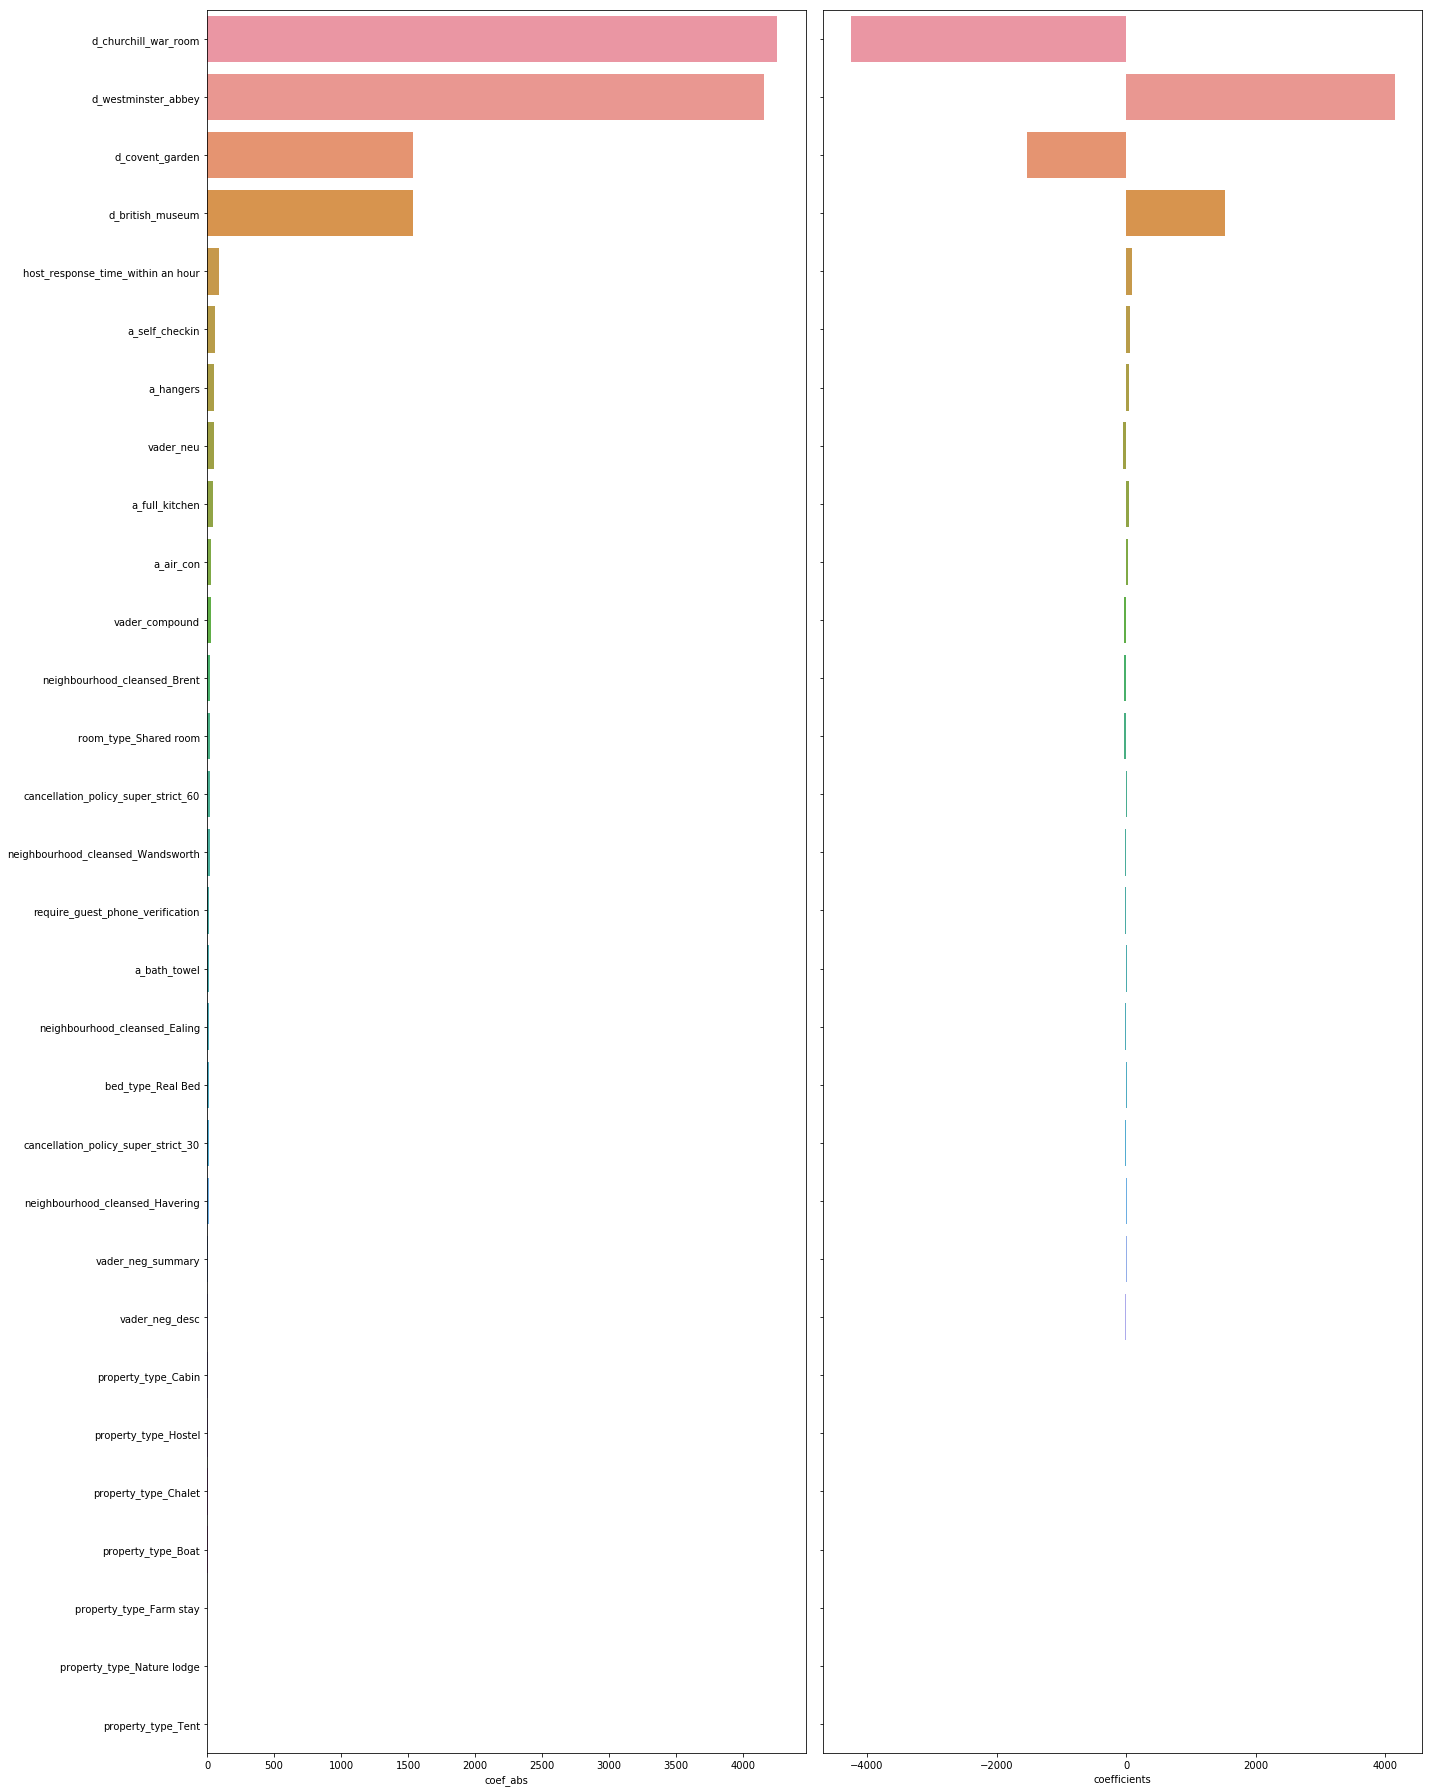

In [101]:
y = data_mf.income
X = dummies

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.3,random_state=1)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

fitter2(lr, X_train, y_train, X_test, y_test)

# The selected 30 features don't perform too well in terms of accuracy.